In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import roc_auc_score,confusion_matrix

plt.style.use('ggplot') #setting style
pd.set_option('display.max_columns', 100) #setting maximum dispaly columns to 100

In [ ]:
# ==================== EDA & VISUALIZATION FUNCTIONS ====================

def missing_analysis(df):
    plt.figure(figsize=(12,8))
    sns.heatmap(data=df.isna())
    plt.title('Missing Data Heatmap')
    missing_data = df.isna().sum()[(df.isna().sum()) > 0] * (100/sum(df.isna().sum()))
    labels = df.isna().sum()[(df.isna().sum()) > 0].index
    plt.figure(figsize=(15,10))
    plt.pie(missing_data, labels=labels, autopct='%1.1f%%')
    plt.title('Missing Data Distribution')
    plt.show()
    return missing_data

print("Highest allowed:",df['cgpa'].mean() + 3*df['cgpa'].std())
print("Lowest allowed:",df['cgpa'].mean() - 3*df['cgpa'].std())
    missing = df.isna().sum()
    missing_pct = (missing / len(df)) * 100
    return pd.DataFrame({'missing_count': missing, 'missing_pct': missing_pct}).sort_values('missing_pct', ascending=False)

def plot_correlation_matrix(df, numeric_cols=None, figsize=(12, 10)):
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns
    corr_matrix = df[numeric_cols].corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()
    return corr_matrix

def plot_distribution(df, column, kde=True, figsize=(10, 6), title=None):
    plt.figure(figsize=figsize)
    sns.histplot(x=df[column], kde=kde)
    plt.title(title or f'Distribution of {column}')
    plt.show()

def plot_distributions_grid(df, columns, ncols=4, figsize=(15, 10)):
    nrows = (len(columns) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten() if nrows > 1 else [axes] if ncols == 1 else axes
    for i, col in enumerate(columns):
        if i < len(axes):
            sns.histplot(df[col], ax=axes[i], kde=True)
            axes[i].set_title(col)
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

def plot_countplot(df, column, figsize=(10, 6), order_by_count=True):
    plt.figure(figsize=figsize)
    order = df[column].value_counts().index if order_by_count else None
    sns.countplot(x=column, data=df, order=order)
    plt.title(f'Count Plot of {column}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_scatter(df, x, y, hue=None, figsize=(10, 8), title=None):
    plt.figure(figsize=figsize)
    sns.scatterplot(x=df[x], y=df[y], hue=df[hue] if hue else None)
    plt.title(title or f'{x} vs {y}')
    plt.legend()
    plt.show()

def plot_boxplot(df, column, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

def plot_value_counts(df, column, top_n=20, figsize=(12, 6)):
    plt.figure(figsize=figsize)
    df[column].value_counts().head(top_n).plot(kind='bar')
    plt.title(f'Top {top_n} Value Counts - {column}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_kde_comparison(df, column, before_col, after_col, figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    df[[before_col]].plot(kind='kde', ax=ax, color='red', label='Before')
    df[[after_col]].plot(kind='kde', ax=ax, color='blue', label='After')
    plt.title(f'KDE Comparison: {column}')
    ax.legend()
    plt.show()

def plot_crosstab_heatmap(df, col1, col2, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    sns.heatmap(pd.crosstab(df[col1], df[col2]), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Crosstab: {col1} vs {col2}')
    plt.tight_layout()
    plt.show()

def get_numeric_summary(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    return df[numeric_cols].describe()

def get_categorical_summary(df):
    cat_cols = df.select_dtypes(include=['object']).columns
    summary = {}
    for col in cat_cols:
        summary[col] = {'unique': df[col].nunique(), 'top_values': df[col].value_counts().head(5).to_dict()}
    return pd.DataFrame(summary).T

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return outliers, lower, upper

def find_string_values_in_numeric(df, column):
    numeric_version = pd.to_numeric(df[column], errors='coerce')
    string_mask = df[column].notna() & numeric_version.isna()
    return df[string_mask][column].value_counts()

def get_unique_characters(df, column):
    all_chars = set(''.join(df[column].astype(str)))
    return sorted(all_chars)

def plot_feature_importance(model, feature_names, figsize=(10, 8)):
    sort_idx = model.feature_importances_.argsort()
    plt.figure(figsize=figsize)
    plt.barh(np.array(feature_names)[sort_idx], model.feature_importances_[sort_idx])
    plt.xlabel("Feature Importance")
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

# ==================== DATA CLEANING FUNCTIONS ====================

def clean_geo_columns(df):
    df_geo = df[['record_id','country_code','country_name','region','income_level',
                 'latitude','longitude','population_millions']].copy()
    
    df_geo['region_cleaned'] = df_geo['region'].str.lower().str.strip()
    df_geo['country_code_cleaned'] = df_geo['country_code'].str.lower().str.strip()
    df_geo['country_name_cleaned'] = df_geo['country_name'].str.lower().str.strip()
    
    df_geo['income_level_cleaned'] = (
        df_geo['income_level'].str.lower().str.replace(' ','').str.strip()
    )
    income_map = {
        'lowermiddle': 'lower-middle', 'lm': 'lower-middle', 
        'developing': 'lowermiddle', 'emerging': 'lowermiddle',
        'uppermiddle': 'upper-middle', 'UPPER_MIDDLE': 'upper-middle', 'um': 'upper-middle',
        'h': 'high', 'rich': 'high', 'developed': 'high', 'highincome': 'high'
    }
    df_geo['income_level_cleaned'] = df_geo['income_level_cleaned'].replace(income_map)
    df_geo['population_millions_cleaned'] = df_geo['population_millions'].abs()
    
    return df_geo

def clean_temporal_columns(df):
    df_temp = df[['date','year','month','week']].copy()
    df_temp['date'] = df_temp['date'].astype(str)
    df_temp['date_cleaned'] = pd.to_datetime(df_temp['date'], errors='coerce', infer_datetime_format=True)
    
    df_temp['year_cleaned'] = (
        df_temp['year'].str.lower().str.replace(' ','').str.strip().str.replace('\t','')
    )
    df_temp['year_cleaned'] = pd.to_numeric(df_temp['year_cleaned'], errors='coerce').round()
    df_temp.loc[df_temp['year_cleaned'] > 2025, 'year_cleaned'] = np.nan
    
    df_temp['month_cleaned'] = pd.to_numeric(df_temp['month'], errors='coerce').round()
    df_temp.loc[df_temp['month_cleaned'] <= 0, 'month_cleaned'] = np.nan
    df_temp.loc[df_temp['month_cleaned'] > 12, 'month_cleaned'] = np.nan
    
    df_temp['week_cleaned'] = (
        df_temp['week'].str.lower().str.replace(' ','').str.strip().str.replace('\t','')
    )
    df_temp['week_cleaned'] = pd.to_numeric(df_temp['week'], errors='coerce').round()
    df_temp.loc[df_temp['week_cleaned'] <= 0, 'week_cleaned'] = np.nan
    df_temp.loc[df_temp['week_cleaned'] > 53, 'week_cleaned'] = np.nan
    
    return df_temp

def clean_climate_columns(df):
    df_clim = df[['temperature_celsius','temp_anomaly_celsius','precipitation_mm',
                  'heat_wave_days','drought_indicator','flood_indicator',
                  'extreme_weather_events']].copy()
    
    invalid_values = ['error', '-', '--', 'missing', 'nan', '#value!', '#ref!', 'na', 'null', '']
    
    df_clim['temperature_celsius_cleaned'] = df_clim['temperature_celsius'].astype(str).str.lower().str.strip()
    df_clim.loc[df_clim['temperature_celsius_cleaned'].isin(invalid_values), 'temperature_celsius_cleaned'] = np.nan
    df_clim['temperature_celsius_cleaned'] = pd.to_numeric(df_clim['temperature_celsius_cleaned'])
    df_clim.loc[df_clim['temperature_celsius_cleaned'] < -21, 'temperature_celsius_cleaned'] = np.nan
    df_clim.loc[df_clim['temperature_celsius_cleaned'] > 38, 'temperature_celsius_cleaned'] = np.nan
    
    df_clim['precipitation_mm_cleaned'] = df_clim['precipitation_mm'].astype(str).str.replace(r'[^\d.-]', '', regex=True)
    df_clim['precipitation_mm_cleaned'] = pd.to_numeric(df_clim['precipitation_mm_cleaned'], errors='coerce')
    
    df_clim['heat_wave_days_round'] = df_clim['heat_wave_days'].round()
    
    binary_map = {'false': 0, 'n': 0, 'no': 0, 'true': 1, 'yes': 1, 'y': 1}
    
    df_clim['drought_indicator_cleaned'] = df_clim['drought_indicator'].str.lower().str.strip()
    df_clim['drought_indicator_cleaned'] = df_clim['drought_indicator_cleaned'].replace(binary_map)
    df_clim['drought_indicator_cleaned'] = pd.to_numeric(df_clim['drought_indicator_cleaned']).round()
    
    df_clim['flood_indicator_cleaned'] = df_clim['flood_indicator'].str.lower().str.strip()
    df_clim['flood_indicator_cleaned'] = df_clim['flood_indicator_cleaned'].replace(binary_map)
    df_clim['flood_indicator_cleaned'] = pd.to_numeric(df_clim['flood_indicator_cleaned']).round()
    
    df_clim['extreme_weather_events_round'] = df_clim['extreme_weather_events'].round()
    
    return df_clim

def clean_air_quality_columns(df):
    df_air = df[['pm25_ugm3','air_quality_index']].copy()
    
    invalid_values = ['error', '-', '--', 'missing', 'nan', '#value!', '#ref!', 'na', 'null', '', 'n/a', 'none']
    
    df_air['pm25_ugm3_cleaned'] = df_air['pm25_ugm3'].astype(str).str.lower().str.strip()
    df_air.loc[df_air['pm25_ugm3_cleaned'].isin(invalid_values), 'pm25_ugm3_cleaned'] = np.nan
    df_air['pm25_ugm3_cleaned'] = pd.to_numeric(df_air['pm25_ugm3_cleaned'])
    df_air.loc[df_air['pm25_ugm3_cleaned'] < 0, 'pm25_ugm3_cleaned'] = np.nan
    
    df_air.loc[df_air['air_quality_index'] < 0, 'air_quality_index'] = np.nan
    
    return df_air

def clean_socioeconomic_columns(df):
    df_socio = df[['healthcare_access_index','gdp_per_capita_usd',
                   'mental_health_index','food_security_index']].copy()
    
    df_socio['healthcare_access_index'] = df_socio['healthcare_access_index'].clip(0, 100)
    df_socio['gdp_per_capita_usd'] = df_socio['gdp_per_capita_usd'].abs()
    df_socio['food_security_index'] = df_socio['food_security_index'].abs()
    
    return df_socio

def process_train_data(df):
    df_geo = clean_geo_columns(df)
    df_temp = clean_temporal_columns(df)
    df_clim = clean_climate_columns(df)
    df_air = clean_air_quality_columns(df)
    df_socio = clean_socioeconomic_columns(df)
    
    geo_cleaned_cols = ['latitude','longitude','income_level_cleaned',
                        'population_millions_cleaned','region_cleaned',
                        'country_name_cleaned','country_code_cleaned']
    temp_cleaned_cols = ['year_cleaned','month_cleaned','week_cleaned']
    clim_cleaned_cols = ['temperature_celsius_cleaned','temp_anomaly_celsius',
                         'precipitation_mm_cleaned','heat_wave_days_round',
                         'drought_indicator_cleaned','flood_indicator_cleaned',
                         'extreme_weather_events_round']
    air_cleaned_cols = ['air_quality_index','pm25_ugm3_cleaned']
    socio_cleaned_cols = ['gdp_per_capita_usd','mental_health_index',
                          'food_security_index','healthcare_access_index']
    
    X = pd.concat([
        df_geo[geo_cleaned_cols],
        df_clim[clim_cleaned_cols],
        df_air[air_cleaned_cols],
        df_socio[socio_cleaned_cols],
        df_temp[temp_cleaned_cols]
    ], axis=1)
    
    y = df['health_risk_class']
    
    return X, y

def process_test_data(df_test):
    df_test = df_test.copy()
    
    df_test['date'] = pd.to_datetime(df_test['date'])
    df_test['year_cleaned'] = df_test['date'].dt.year
    df_test['month_cleaned'] = df_test['date'].dt.month
    df_test['week_cleaned'] = df_test['date'].dt.isocalendar().week
    
    df_test['region_cleaned'] = df_test['region']
    df_test['country_name_cleaned'] = df_test['country_name']
    df_test['country_code_cleaned'] = df_test['country_code']
    
    df_test['income_level_cleaned'] = df_test['income_level'].str.lower().str.strip()
    
    df_test['population_millions_cleaned'] = df_test['population_millions']
    df_test['temperature_celsius_cleaned'] = df_test['temperature_celsius']
    df_test['precipitation_mm_cleaned'] = df_test['precipitation_mm']
    df_test['pm25_ugm3_cleaned'] = df_test['pm25_ugm3']
    df_test['heat_wave_days_round'] = df_test['heat_wave_days']
    df_test['drought_indicator_cleaned'] = df_test['drought_indicator']
    df_test['flood_indicator_cleaned'] = df_test['flood_indicator']
    df_test['extreme_weather_events_round'] = df_test['extreme_weather_events']
    
    return df_test

def apply_ordinal_encoding(X_train, X_test, ordinal_features, categories):
    from sklearn.preprocessing import OrdinalEncoder
    encoder = OrdinalEncoder(categories=categories, handle_unknown='use_encoded_value', unknown_value=-1)
    X_train[ordinal_features] = encoder.fit_transform(X_train[ordinal_features])
    X_test[ordinal_features] = encoder.transform(X_test[ordinal_features])
    X_train[ordinal_features[0]] = X_train[ordinal_features[0]].replace(-1, np.nan)
    X_test[ordinal_features[0]] = X_test[ordinal_features[0]].replace(-1, np.nan)
    return X_train, X_test, encoder

def apply_frequency_encoding(X_train, X_test, freq_cols):
    freq_maps = {}
    for col in freq_cols:
        freq = X_train[col].value_counts(normalize=True)
        freq_maps[col] = freq
        X_train[f'{col}_freq'] = X_train[col].map(freq)
        X_test[f'{col}_freq'] = X_test[col].map(freq).fillna(0)
    return X_train, X_test, freq_maps

def impute_and_scale(X_train, X_test, num_cols, cat_cols):
    from sklearn.impute import SimpleImputer, KNNImputer
    from sklearn.preprocessing import StandardScaler
    
    knn_imputer = KNNImputer(n_neighbors=5)
    X_train_num_imputed = knn_imputer.fit_transform(X_train[num_cols])
    X_test_num_imputed = knn_imputer.transform(X_test[num_cols])
    
    simple_imputer = SimpleImputer(strategy='most_frequent')
    X_train_cat_imputed = simple_imputer.fit_transform(X_train[cat_cols])
    X_test_cat_imputed = simple_imputer.transform(X_test[cat_cols])
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_num_imputed)
    X_test_scaled = scaler.transform(X_test_num_imputed)
    
    X_train_cat_df = pd.DataFrame(X_train_cat_imputed, columns=cat_cols)
    X_test_cat_df = pd.DataFrame(X_test_cat_imputed, columns=cat_cols)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=num_cols)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=num_cols)
    
    X_train_final = pd.concat([X_train_cat_df, X_train_scaled_df], axis=1)
    X_test_final = pd.concat([X_test_cat_df, X_test_scaled_df], axis=1)
    
    return X_train_final, X_test_final, knn_imputer, simple_imputer, scaler

def prepare_submission_data(df_test, encoder, freq_maps, scaler, num_cols, feature_columns):
    df_test = process_test_data(df_test)
    df_test[['income_level_cleaned']] = encoder.transform(df_test[['income_level_cleaned']])
    
    for col in freq_maps.keys():
        df_test[f'{col}_freq'] = df_test[col].map(freq_maps[col]).fillna(0)
    
    df_test[num_cols] = scaler.transform(df_test[num_cols])
    
    return df_test[feature_columns]

def create_submission(model, X_submission, record_ids, filename='submission.csv'):
    predictions = model.predict_proba(X_submission)
    submission = pd.DataFrame({
        'record_id': record_ids,
        'Low_Risk': predictions[:, 0],
        'Moderate_Risk': predictions[:, 1],
        'High_Risk': predictions[:, 2],
        'Critical_Risk': predictions[:, 3]
    })
    submission.to_csv(filename, index=False)
    return submission

In [2]:
df = pd.read_csv('/kaggle/input/datathon-techparva-2026/train.csv')

In [3]:
df_test = pd.read_csv("/kaggle/input/datathon-techparva-2026/test.csv")

## EDA Using Functions

In [ ]:
print(f"Train shape: {df.shape}")
print(f"Test shape: {df_test.shape}")
df.sample(5)

In [ ]:
get_numeric_summary(df)

In [ ]:
get_categorical_summary(df)

In [ ]:
get_missing_summary(df).head(15)

In [ ]:
missing_analysis(df)

In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plot_correlation_matrix(df, numeric_cols)

In [ ]:
plot_distributions_grid(df, numeric_cols, ncols=4, figsize=(16, 12))

In [ ]:
plot_countplot(df, 'health_risk_class')

In [ ]:
plot_scatter(df, 'gdp_per_capita_usd', 'healthcare_access_index', hue='health_risk_class', title='GDP vs Healthcare Access by Risk Class')

In [ ]:
plot_scatter(df, 'latitude', 'longitude', hue='health_risk_class', title='Geographic Distribution by Risk Class')

In [ ]:
plot_value_counts(df, 'region', top_n=15)

In [ ]:
plot_value_counts(df, 'income_level', top_n=10)

In [ ]:
plot_distribution(df, 'temperature_celsius', title='Temperature Distribution')
plot_distribution(df, 'air_quality_index', title='Air Quality Index Distribution')

In [ ]:
find_string_values_in_numeric(df, 'temperature_celsius')

In [ ]:
find_string_values_in_numeric(df, 'pm25_ugm3')

In [ ]:
plot_boxplot(df, 'gdp_per_capita_usd')
plot_boxplot(df, 'population_millions')

In [ ]:
outliers, lower, upper = detect_outliers_iqr(df, 'population_millions')
print(f"Outliers in population_millions: {len(outliers)} rows")
print(f"Lower bound: {lower:.2f}, Upper bound: {upper:.2f}")

In [ ]:
print("Unique characters in 'year' column:")
get_unique_characters(df, 'year')

In [4]:
df.shape

(12842, 26)

In [5]:
df_test.shape

(1692, 25)

In [6]:
df.sample(5)

,record_id,flood_indicator,country_code,week,temperature_celsius,pm25_ugm3,region,gdp_per_capita_usd,month,precipitation_mm,mental_health_index,year,longitude,food_security_index,latitude,healthcare_access_index,drought_indicator,income_level,extreme_weather_events,heat_wave_days,date,country_name,population_millions,air_quality_index,temp_anomaly_celsius,health_risk_class
9498,9499,0.0,FRA,13.0,8.84,1.8,Europe,64971.0,3.0,177.3,79.3,2019.0,2.21,100.0,46.22,87.0,0.0,High Income,0.0,0.0,31-Mar-2019,France,65.0,55.0,0.85,1
112,113,0.0,NGA,15.0,27.83,89.2,Africa,2485.0,4.0,96.8,61.4,2016.0,8.67,NaN,9.08,39.8,0.0,Lower-Middle,0.0,0.0,2016-04-17,Nigeria,206.0,147.0,0.11,3
1683,1684,0.0,CAN,51.0,NaN,22.5,North America,NaN,12.0,NaN,71.3,2017.0,-106.34,99.9,56.13,NaN,0.0,High,0.0,0.0,24-Dec-2017,Canada,38.0,23.0,0.62,0
674,675,0.0,MEX,43.0,4.41,75.3,North America,17187.0,10.0,60.4,75.3,2023.0,-102.55,NaN,NaN,NaN,0.0,Upper-Middle,0.0,0.0,"October 29, 2023",Mexico\t,129.0,NaN,0.04,1
12086,12087,0.0,CAN,42.0\t,-16.74,48.0,North America,44549.0,10.0,65.6,68.6,2023.0,-106.34,100.0,56.13,NaN,0.0,High,0.0,NaN,22.10.2023,Canada,38.0,71.0,-0.09,1


In [7]:
df.describe()

,record_id,gdp_per_capita_usd,mental_health_index,longitude,food_security_index,latitude,healthcare_access_index,extreme_weather_events,heat_wave_days,population_millions,air_quality_index,temp_anomaly_celsius,health_risk_class
count,12842.000000,11878.000000,9126.000000,11314.000000,8060.000000,11932.000000,8554.000000,12196.000000,12145.000000,11331.000000,11378.000000,12067.000000,12842.000000
mean,6421.500000,26134.737760,69.866467,30.556847,93.395165,21.938629,64.842716,0.168169,0.149443,215.341145,97.851409,0.123147,1.403052
std,3707.310413,26315.881181,5.021787,83.890824,6.298881,40.005966,18.244755,0.482075,0.458391,354.506742,60.479689,0.504928,0.975751
min,1.000000,-99.732182,47.700000,-106.375592,65.300000,-38.443338,28.100000,0.000000,0.000000,-98.522545,-99.307549,-1.760000,0.000000
25%,3211.250000,3528.153901,66.500000,-3.740000,88.900000,4.570000,46.900000,0.000000,0.000000,60.000000,53.000000,-0.220000,1.000000
50%,6421.500000,13796.094953,70.000000,22.930000,94.600000,23.630000,66.250000,0.000000,0.000000,98.000000,92.000000,0.130000,1.000000
75%,9631.750000,49965.000000,73.300000,100.990000,99.900000,37.090000,81.600000,0.000000,0.000000,206.000000,142.000000,0.460000,2.000000
max,12842.000000,78630.000000,88.700000,499.937305,100.177448,497.991552,102.000000,5.000000,5.000000,1412.914623,302.000000,2.120000,3.000000


In [8]:
# !pip install ydata-profiling
# from ydata_profiling import ProfileReport
# profile = ProfileReport(df, title="Profiling Report")
# profile.to_file("eda_report_tech_parva_2026.html")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12842 entries, 0 to 12841
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   record_id                12842 non-null  int64  
 1   flood_indicator          11604 non-null  object 
 2   country_code             12842 non-null  object 
 3   week                     11869 non-null  object 
 4   temperature_celsius      11101 non-null  object 
 5   pm25_ugm3                11911 non-null  object 
 6   region                   12204 non-null  object 
 7   gdp_per_capita_usd       11878 non-null  float64
 8   month                    12202 non-null  object 
 9   precipitation_mm         11630 non-null  object 
 10  mental_health_index      9126 non-null   float64
 11  year                     11409 non-null  object 
 12  longitude                11314 non-null  float64
 13  food_security_index      8060 non-null   float64
 14  latitude              

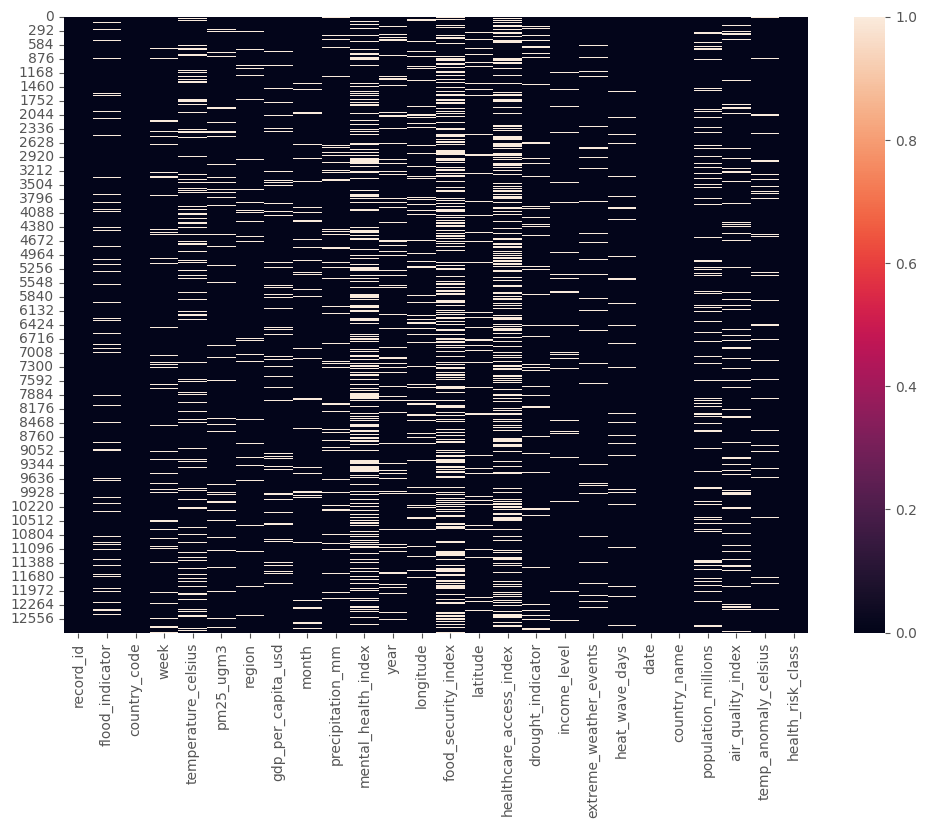

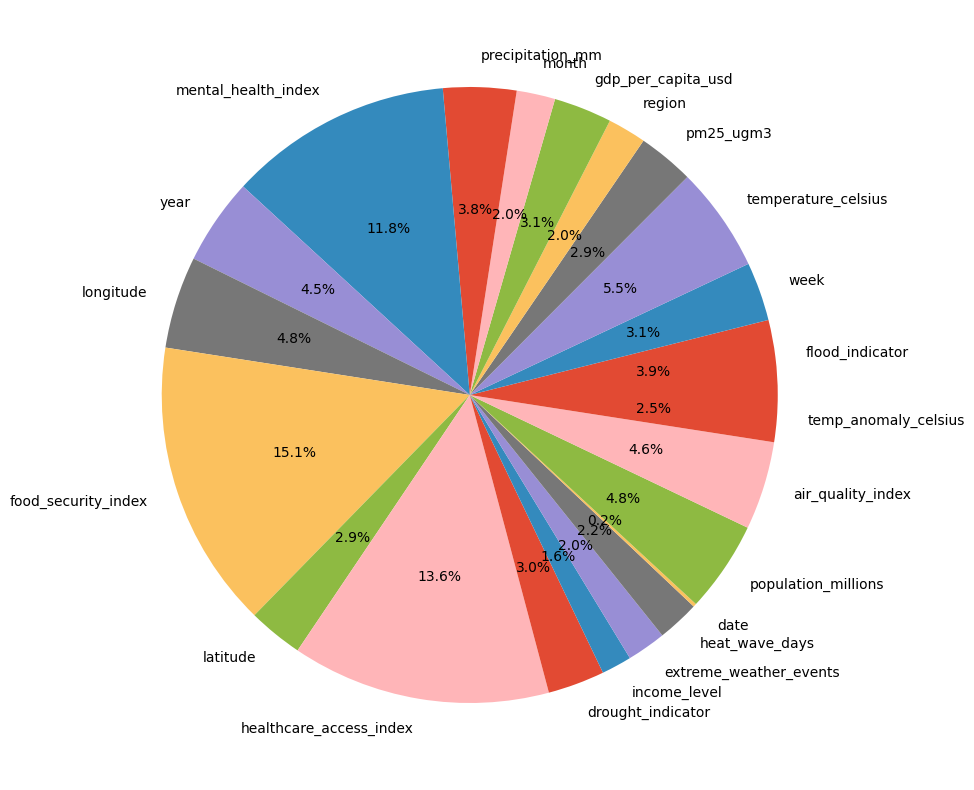

In [10]:
def missing_analysis(df):
    ''' Generating Heatmap and Piechart to visualize the missing data'''
    plt.figure(figsize=(12,8))
    heatm = sns.heatmap(data=df.isna())
    missing_data = df.isna().sum()[(df.isna().sum()) > 0] * (100/sum(df.isna().sum()))
    labels = df.isna().sum()[(df.isna().sum()) > 0].index

    plt.figure(figsize=(15,10))
    plt.pie(missing_data,labels = labels, autopct='%1.1f%%')
    plt.show()
    
missing_analysis(df)

In [11]:
missing_data = df.isna().sum()[(df.isna().sum()) > 0] * (100/sum(df.isna().sum()))
missing_data

flood_indicator             3.919830
week                        3.080771
temperature_celsius         5.512459
pm25_ugm3                   2.947788
region                      2.020074
gdp_per_capita_usd          3.052275
month                       2.026407
precipitation_mm            3.837508
mental_health_index        11.765823
year                        4.537251
longitude                   4.838046
food_security_index        15.141057
latitude                    2.881297
healthcare_access_index    13.576924
drought_indicator           2.982617
income_level                1.583130
extreme_weather_events      2.045404
heat_wave_days              2.206883
date                        0.170978
population_millions         4.784219
air_quality_index           4.635405
temp_anomaly_celsius        2.453852
dtype: float64

In [12]:
numeric_columns = [col for col in df.columns if df[col].dtype != 'object']
df_numeric = df[numeric_columns]
df_numeric.head(5)

,record_id,gdp_per_capita_usd,mental_health_index,longitude,food_security_index,latitude,healthcare_access_index,extreme_weather_events,heat_wave_days,population_millions,air_quality_index,temp_anomaly_celsius,health_risk_class
0,1,2700.0,NaN,78.96,NaN,20.59,50.7,0.0,0.0,NaN,138.0,0.52,1
1,2,4174.0,70.6,30.80,NaN,26.82,41.1,0.0,0.0,102.0,175.0,-0.31,2
2,3,2606.0,67.1,78.96,NaN,20.59,48.9,0.0,0.0,1380.0,176.0,-0.97,1
3,4,NaN,69.5,104.19,100.0,35.86,69.1,0.0,0.0,1411.0,123.0,0.76,1
4,5,2963.0,73.6,78.96,96.1,20.59,46.3,0.0,0.0,1380.0,159.0,0.12,1


In [13]:
obj_columns = [col for col in df.columns if df[col].dtype == 'object']
df_obj = df[obj_columns]
df_obj.head(5)

,flood_indicator,country_code,week,temperature_celsius,pm25_ugm3,region,month,precipitation_mm,year,drought_indicator,income_level,date,country_name
0,0.0,IND,39.0,6.8,93.3,South Asia,9.0,49.5,2019.0,0.0,Lower Middle,2019/09/29,India
1,0.0,EGY,11.0\t,63.032,NaN,Africa,3.0,153.7,2020.0,0.0,Lower-Middle,15/03/2020,Egypt
2,0.0,IND\t,40.0,3.51,111.6,South Asia,10.0,51.1,2017.0,0.0,LOWER-MIDDLE,08/10/2017,India
3,0.0,CHN,33.0,NaN,81.1,East Asia,8.0,18.2,2016.0,0.0,Upper-Middle,21.08.2016,China
4,NaN,IND,1.0,NaN,114.2,South Asia,1.0,134.5,2025.0,0.0,Lower-Middle,05/01/2025,India


In [14]:
df_obj[['flood_indicator','week','temperature_celsius','pm25_ugm3','month','precipitation_mm','year','drought_indicator','date']].sample(10)

,flood_indicator,week,temperature_celsius,pm25_ugm3,month,precipitation_mm,year,drought_indicator,date
4300,False,7.0,7.91,86.8,2.0,NaN,NaN,0.0,"February 16, 2020"
7414,0.0,42.0,0.21,91.3,10.0,99.4,2025.0,0.0,10-19-2025
12600,0.0,27.0,7.91,89.5,7.0,79.1,NaN,NaN,07/07/2024
510,0.0,NaN,7.38,0.0,5.0,96.4,2020.0,0.0,2020-05-24
6636,0.0,27.0,NaN,11.0,7.0,121.0,2016.0,0.0,07-10-2016
12409,NaN,NaN,-5.73,59.9,1.0,117.7,2025.0,0.0,20250105
1791,0.0,5.0,13.57,92.9,2.0,90.7,2019.0,0.0,737093
5465,False,13.0,21.25,NaN,4.0,97.3,2018.0,0.0,20180401
7648,False,20.0,-2.02,42.0,5.0,NaN,2021.0,0.0,20210523
3208,NaN,30.0,17.19,85.4,7.0,68.6,2020.0,0.0,26.07.2020


In [15]:
df.duplicated().sum()

np.int64(0)

In [16]:
df['drought_indicator'].value_counts(),# df['drought_indicator'].isna().sum()

(drought_indicator
 0.0                   10777
 False                   172
 N                       165
 No                      165
 no                      164
 FALSE                   161
 0                       151
 1.0                     133
 1                         3
 TRUE                      2
 Yes                       1
 Y                         1
 yes                       1
 True                      1
 1.0000321483312822        1
 0.999085341107566         1
 1.0001426094682164        1
 Name: count, dtype: int64,)

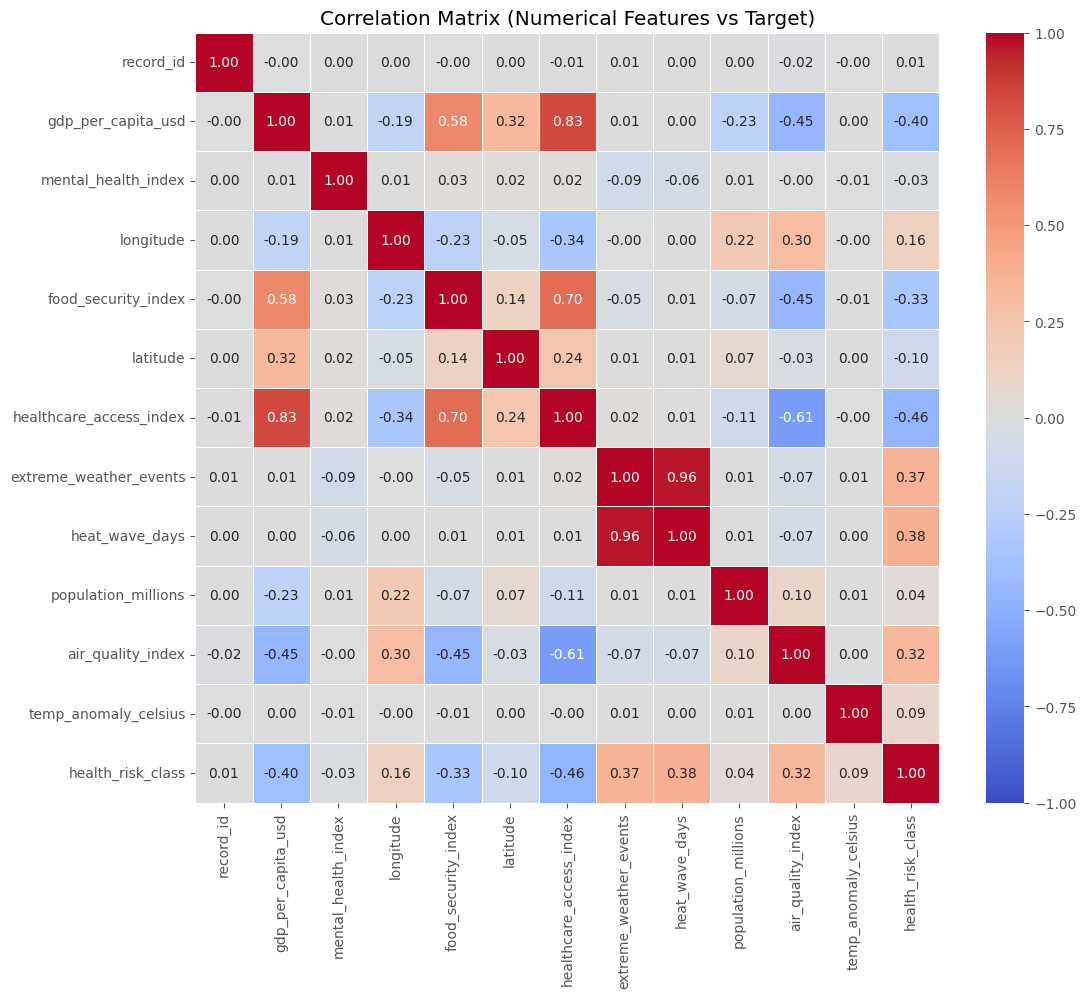

In [17]:
numeric_columns_grade = df_numeric.columns
corr_features = numeric_columns_grade 
corr_matrix = df[corr_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", 
            cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix (Numerical Features vs Target)')
plt.show()


- air_quality_index is highly overall correlated with gdp_per_capita_usd and health_care_access_index	High correlation
- extreme_weather_events is highly overall correlated with heat_wave_days	High correlation
- food_security_index is highly overall correlated with gdp_per_capita_usd and health_care_access_index	High correlation
- gdp_per_capita_usd is highly overall correlated with air_quality_index and 3 other fields	High correlation
- healthcare_access_index is highly overall correlated with air_quality_index and 3 other fields	High correlation
- heat_wave_days is highly overall correlated with extreme_weather_events	High correlation
- latitude is highly overall correlated with gdp_per_capita_usd and 1 other fields

In [18]:
# df[numeric_columns].hist(bins=30, figsize=(15, 10))
# plt.tight_layout()
# plt.show()

In [19]:
# import scipy.stats as stats
# fig, axes = plt.subplots(4, 4, figsize=(20, 15))
# axes = axes.flatten()

# for i, col in enumerate(numeric_columns):
#     stats.probplot(df[col], dist="norm", plot=axes[i])
#     axes[i].set_title(col)

# plt.tight_layout()
# plt.show()

In [20]:
# sns.countplot(x='health_risk_class',data=df,order= df['health_risk_class'].value_counts().index)

The data seems to be imbalanced

## Geographic and Identification columns

- record_id	Integer	Unique identifier	Primary key
- country_code	String	ISO 3166-1 alpha-3 code	e.g., USA, IND, CHN
- country_name	String	Full country name	May have variations
- region	Categorical	Geographic region	May have inconsistencies
- income_level	Categorical	World Bank classification	High, Upper-Middle, Lower-Middle
- latitude	Float	Geographic latitude	-90 to 90
- longitude	Float	Geographic longitude	-180 to 180
- population_millions

In [21]:
geo_id_cols = ['record_id','country_code','country_name','region','income_level',
              'latitude','longitude','population_millions']

In [22]:
df[geo_id_cols].head(5)

,record_id,country_code,country_name,region,income_level,latitude,longitude,population_millions
0,1,IND,India,South Asia,Lower Middle,20.59,78.96,NaN
1,2,EGY,Egypt,Africa,Lower-Middle,26.82,30.80,102.0
2,3,IND\t,India,South Asia,LOWER-MIDDLE,20.59,78.96,1380.0
3,4,CHN,China,East Asia,Upper-Middle,35.86,104.19,1411.0
4,5,IND,India,South Asia,Lower-Middle,20.59,78.96,1380.0


In [23]:
df_geo = df[geo_id_cols] 
df_geo.head(5)

,record_id,country_code,country_name,region,income_level,latitude,longitude,population_millions
0,1,IND,India,South Asia,Lower Middle,20.59,78.96,NaN
1,2,EGY,Egypt,Africa,Lower-Middle,26.82,30.80,102.0
2,3,IND\t,India,South Asia,LOWER-MIDDLE,20.59,78.96,1380.0
3,4,CHN,China,East Asia,Upper-Middle,35.86,104.19,1411.0
4,5,IND,India,South Asia,Lower-Middle,20.59,78.96,1380.0


### Lat vs Lon

In [24]:
# plt.figure(figsize=(10, 8))
# sns.scatterplot(y=df['latitude'],x=df['longitude'],hue=df['health_risk_class'])
# plt.title('Scatter Plot of latitude vs longitude')
# plt.legend()
# plt.show()

### Region (inconsistent and spelling mistakes in the data)

In [25]:
df['region'].value_counts().tail(20)

region
North Aerica              1
African Continent         1
Afrcia\t                  1
  Sub-Saharan Africa      1
Afeica                    1
  east asia               1
South Amyrica             1
Souh America              1
Erope                     1
  south america           1
South mAerica             1
Ocenaia                   1
S. Amerca                 1
Afrira                    1
Sub-Saharan Africa        1
North cmerica             1
  europe                  1
europe                    1
Afzica                    1
Soutc America             1
Name: count, dtype: int64

In [26]:
# sns.histplot(x='region',data=df)

In [27]:
df_geo['region_cleaned'] = (
    df_geo['region']
    .str.lower()
    .str.strip()
)
df_geo['region_cleaned'].tail(5)

/tmp/ipykernel_110/934046326.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo['region_cleaned'] = (


12837         north america
12838                africa
12839    sub-saharan africa
12840            south asia
12841            south asia
Name: region_cleaned, dtype: object

In [28]:
df_test['region'].value_counts()

region
Europe            340
Southeast Asia    288
Africa            246
South America     217
South Asia        210
North America     181
East Asia         133
Oceania            77
Name: count, dtype: int64

### Country Code

In [29]:
df_geo['country_code_cleaned'] = (
    df_geo['country_code']
    .str.lower()
    .str.strip()
)
df_geo['country_code_cleaned']

/tmp/ipykernel_110/1284502583.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo['country_code_cleaned'] = (


0        ind
1        egy
2        ind
3        chn
4        ind
        ... 
12837    usa
12838    nga
12839    nga
12840    pak
12841    ind
Name: country_code_cleaned, Length: 12842, dtype: object

### Country name

In [30]:
df_geo['country_name_cleaned'] = (
    df_geo['country_name']
    .str.lower()
    .str.strip()
)
df_geo['country_name_cleaned']

/tmp/ipykernel_110/3837082674.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo['country_name_cleaned'] = (


0                india
1                egypt
2                india
3                china
4                india
             ...      
12837    united states
12838          nigeria
12839          nigeria
12840         pakistan
12841            india
Name: country_name_cleaned, Length: 12842, dtype: object

In [31]:
# Print rows where country_code appears less than 5 times
rare_rows = df_geo[df_geo['country_name_cleaned'].isin(df_geo['country_name_cleaned'].value_counts()[df_geo['country_name_cleaned'].value_counts() < 5].index)]
rare_rows['country_name_cleaned']

73                      indira
162                      kekya
207                   pakistna
233      reupblic of indonesia
251                     frnace
                 ...          
12732                   fraqce
12814                    knnya
12825                 austraia
12831              banqgladesh
12832                    keyna
Name: country_name_cleaned, Length: 262, dtype: object

In [32]:
# df_geo['country_cleaned'].value_counts()

### Income level

In [33]:
df['income_level'].value_counts().tail(20)

income_level
Developed           1
Rich                1
  LM                1
LM                  1
  H                 1
  lower-middle      1
upper-middle        1
  Upper Middle      1
Developing\t        1
  UPPER-MIDDLE      1
  UPPER-MIDDLE      1
  LOWER-MIDDLE      1
  UM                1
Developing          1
UM\t                1
  Lower Middle      1
  High Income       1
LOWER-MIDDLE        1
HIGH                1
upper-middle\t      1
Name: count, dtype: int64

In [34]:
df_geo['income_level_cleaned'] = (
    df_geo['income_level']
    .str.lower()
    .str.replace(' ','')
    .str.strip()
)
df_geo['income_level_cleaned'].value_counts()

/tmp/ipykernel_110/440806333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo['income_level_cleaned'] = (


income_level_cleaned
lower-middle    3888
high            3829
upper-middle    3022
lowermiddle      195
lm               192
rich             177
emerging         168
developing       167
h                151
uppermiddle      151
developed        151
um               133
highincome       118
Name: count, dtype: int64

In [35]:
income_map = {
    # lower middle
    'lowermiddle': 'lower-middle',
    'lm': 'lower-middle',
    'developing': 'lowermiddle',
    'emerging': 'lowermiddle',

    # upper middle
    'uppermiddle': 'upper-middle',
    'UPPER_MIDDLE': 'upper-middle',
    'um': 'upper-middle',

    # high income
    'h': 'high',
    'rich': 'high',
    'developed': 'high',
    'highincome': 'high'
}

df_geo['income_level_cleaned'] = df_geo['income_level_cleaned'].replace(income_map)


/tmp/ipykernel_110/1706491191.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo['income_level_cleaned'] = df_geo['income_level_cleaned'].replace(income_map)


In [36]:
df_geo['income_level_cleaned'].value_counts()

income_level_cleaned
high            4426
lower-middle    4275
upper-middle    3306
lowermiddle      335
Name: count, dtype: int64

### Population in millions

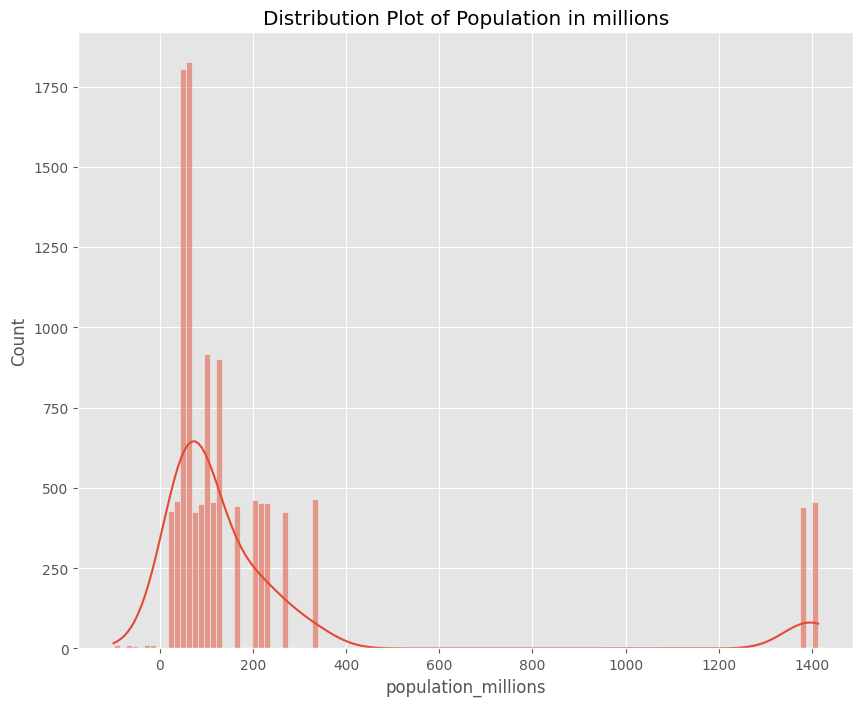

In [37]:
plt.figure(figsize=(10, 8))
sns.histplot(x=df['population_millions'],kde=True)
plt.title('Distribution Plot of Population in millions')
plt.show()

In [38]:
df_geo['population_millions'].describe()

count    11331.000000
mean       215.341145
std        354.506742
min        -98.522545
25%         60.000000
50%         98.000000
75%        206.000000
max       1412.914623
Name: population_millions, dtype: float64

In [39]:
df_geo['population_millions'][df_geo['population_millions'] < 0]

187     -28.099238
300     -72.333271
487     -73.572082
589     -33.919790
1125    -81.877971
           ...    
11417   -74.094068
11723   -47.227492
12083   -85.860441
12488   -64.089051
12651   -85.860441
Name: population_millions, Length: 64, dtype: float64

In [40]:
df.iloc[487,:]

record_id                           488
flood_indicator                     0.0
country_code                        PAK
week                               36.0
temperature_celsius               -0.71
pm25_ugm3                         142.1
region                       South Asia
gdp_per_capita_usd               4430.0
month                               9.0
precipitation_mm                 86.3\t
mental_health_index                70.2
year                             2023.0
longitude                         69.34
food_security_index                 NaN
latitude                          30.37
healthcare_access_index            60.7
drought_indicator                   0.0
income_level               Lower-Middle
extreme_weather_events              0.0
heat_wave_days                      0.0
date                         2023/09/10
country_name                   Pakistan
population_millions          -73.572082
air_quality_index                 207.0
temp_anomaly_celsius              -0.48


In [41]:
df_geo['population_millions_cleaned'] = df_geo['population_millions'].abs()

/tmp/ipykernel_110/4253978923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo['population_millions_cleaned'] = df_geo['population_millions'].abs()


In [42]:
df_geo['population_millions_cleaned'].describe()

count    11331.000000
mean       215.913965
std        354.158124
min          3.855693
25%         60.000000
50%         98.000000
75%        206.000000
max       1412.914623
Name: population_millions_cleaned, dtype: float64

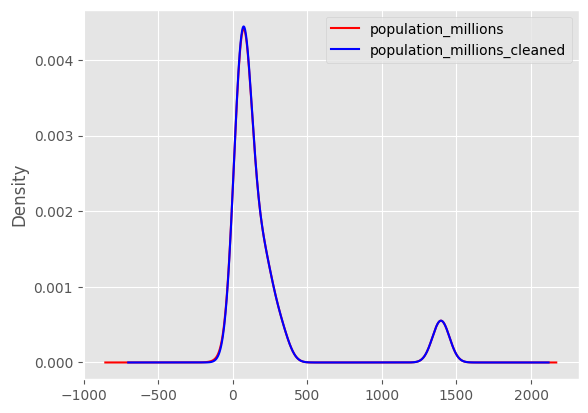

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)

df_geo[['population_millions']].plot(kind='kde', ax=ax,color='red')
df_geo[['population_millions_cleaned']].plot(kind='kde', ax=ax, color='blue')

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

## Temporal Columns

- date	String	Week start date	Multiple formats in training!
- year	Integer	Calendar year (2015-2025)	May have invalid values
- month	Integer	Month of year (1-12)	May have invalid values
- week	Integer	ISO week number (1-53)	May have format issues

In [44]:
temporal_columns = ['date','year','month','week']
df_temp = df[temporal_columns]
df_temp

,date,year,month,week
0,2019/09/29,2019.0,9.0,39.0
1,15/03/2020,2020.0,3.0,11.0\t
2,08/10/2017,2017.0,10.0,40.0
3,21.08.2016,2016.0,8.0,33.0
4,05/01/2025,2025.0,1.0,1.0
...,...,...,...,...
12837,04/02/2024,NaN,2.0005622785000163,5.003809370996368
12838,"February 16, 2020",2023.9861999890134,2.0010168232190093,NaN
12839,738262,2024.2546235305297,4.000796259669452,15.012183050088137
12840,06.11.2016,2015.515321575176,10.996978970705175,44.037952127977334


### date

In [45]:
df['date']

0               2019/09/29
1               15/03/2020
2               08/10/2017
3               21.08.2016
4               05/01/2025
               ...        
12837           04/02/2024
12838    February 16, 2020
12839             738262  
12840           06.11.2016
12841           17.05.2020
Name: date, Length: 12842, dtype: object

In [46]:

# new_df['date'] = pd.to_datetime(new_df['date'])

In [47]:
df_temp['date'] = df_temp['date'].astype(str) 

/tmp/ipykernel_110/3008050865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['date'] = df_temp['date'].astype(str)


In [48]:
df_temp['date_cleaned'] = (
    df_temp['date'].
    str.replace('.','/')
)

/tmp/ipykernel_110/3976824022.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['date_cleaned'] = (


In [49]:
df_temp['date_cleaned'].value_counts().tail(20)

date_cleaned
March 24, 2024        1
2019/11/17            1
08-27-2017            1
  01-Nov-2015         1
June 27, 2021         1
12-Dec-2021           1
20230730\t            1
11-Jun-2017           1
  2025/01/12          1
  20241208            1
03-31-2019            1
737485                1
  02-07-2016          1
24/03/2024            1
22-Apr-2018\t         1
2016-11-13            1
2019/10/20            1
January 30, 2022      1
2023/11/19            1
02-03-2019            1
Name: count, dtype: int64

In [50]:
df_temp['date_cleaned'] = pd.to_datetime(df_temp['date'], errors='coerce', infer_datetime_format=True)

# Check what failed
failed = df_temp[df_temp['date_cleaned'].isna()]['date']
print(f"Failed to parse: {len(failed)} dates")
print(failed.head())

Failed to parse: 11499 dates
1     15/03/2020
2     08/10/2017
3     21.08.2016
4     05/01/2025
7    10-Mar-2019
Name: date, dtype: object


/tmp/ipykernel_110/1374782092.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_temp['date_cleaned'] = pd.to_datetime(df_temp['date'], errors='coerce', infer_datetime_format=True)
/tmp/ipykernel_110/1374782092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['date_cleaned'] = pd.to_datetime(df_temp['date'], errors='coerce', infer_datetime_format=True)


### year

In [51]:
df_temp['year']

0                        2019.0
1                        2020.0
2                        2017.0
3                      2016.0  
4                        2025.0
                  ...          
12837                       NaN
12838        2023.9861999890134
12839      2024.2546235305297  
12840         2015.515321575176
12841        2018.5915331141553
Name: year, Length: 12842, dtype: object

In [52]:
df_temp['year_cleaned'] =  (
    df_temp['year']
    .str.lower()
    .str.replace(' ','')
    .str.strip()
    .str.replace('\t','')
)

/tmp/ipykernel_110/3127155085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['year_cleaned'] =  (


In [53]:
all_chars = set(''.join(df_temp['year'].astype(str)))
print(f"Unique characters: {sorted(all_chars)}")
print(f"Total unique characters: {len(all_chars)}")

Unique characters: ['\t', ' ', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'I', 'a', 'k', 'l', 'n', 'o', 'u', 'w']
Total unique characters: 21


In [54]:
df_temp['year_cleaned'] = pd.to_numeric(df_temp['year_cleaned'], errors='coerce')

/tmp/ipykernel_110/869883012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['year_cleaned'] = pd.to_numeric(df_temp['year_cleaned'], errors='coerce')


In [55]:
df_temp['year_cleaned'] = df_temp['year_cleaned'].round()
df_temp['year_cleaned'].value_counts()

/tmp/ipykernel_110/3989806506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['year_cleaned'] = df_temp['year_cleaned'].round()


year_cleaned
2023.0    1050
2015.0    1040
2017.0    1037
2016.0    1035
2022.0    1030
2020.0    1027
2018.0    1023
2021.0    1013
2024.0    1007
2019.0    1003
2025.0     822
2030.0      52
1900.0      42
2050.0      37
1850.0      37
2026.0       9
2014.0       7
2013.0       4
2027.0       4
2012.0       1
2028.0       1
2029.0       1
2011.0       1
Name: count, dtype: int64

In [56]:
df_temp.loc[df_temp['year_cleaned'] > 2025, 'year_cleaned'] = np.nan
df_temp['year_cleaned'].value_counts()

year_cleaned
2023.0    1050
2015.0    1040
2017.0    1037
2016.0    1035
2022.0    1030
2020.0    1027
2018.0    1023
2021.0    1013
2024.0    1007
2019.0    1003
2025.0     822
1900.0      42
1850.0      37
2014.0       7
2013.0       4
2012.0       1
2011.0       1
Name: count, dtype: int64

### month

In [ ]:
all_chars = set(''.join(df_temp['month'].astype(str)))
print(f"Unique characters: {sorted(all_chars)}")
print(f"Total unique characters: {len(all_chars)}")

In [58]:
df_temp['month_cleaned'] = pd.to_numeric(df_temp['month'], errors='coerce')
df_temp['month_cleaned'] = df_temp['month_cleaned'].round()

/tmp/ipykernel_110/3217382647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['month_cleaned'] = pd.to_numeric(df_temp['month'], errors='coerce')
/tmp/ipykernel_110/3217382647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['month_cleaned'] = df_temp['month_cleaned'].round()


In [59]:
df_temp['month_cleaned'].value_counts().tail(20)

month_cleaned
 1.0     1081
 3.0     1072
 8.0     1050
 7.0     1043
 5.0     1033
 10.0    1024
 9.0     1007
 6.0     1007
 4.0     1001
 12.0     949
 2.0      925
 11.0     882
 14.0      26
 13.0      21
-1.0       21
 0.0       19
Name: count, dtype: int64

In [60]:
df_temp[['date','month_cleaned']][df_temp['month_cleaned'] < 0].head()

,date,month_cleaned
911,08.08.2021,-1.0
1315,"February 07, 2021",-1.0
1600,736134,-1.0
1677,07-14-2019,-1.0
1782,"January 14, 2024",-1.0


In [61]:
df_temp[['date','month_cleaned']][df_temp['month_cleaned'] > 12].head()

,date,month_cleaned
24,17/08/2025,13.0
374,2025-07-20,14.0
431,"April 09, 2023",14.0
1050,01.01.2023,13.0
1088,24/09/2017,14.0


<Axes: xlabel='month_cleaned', ylabel='count'>

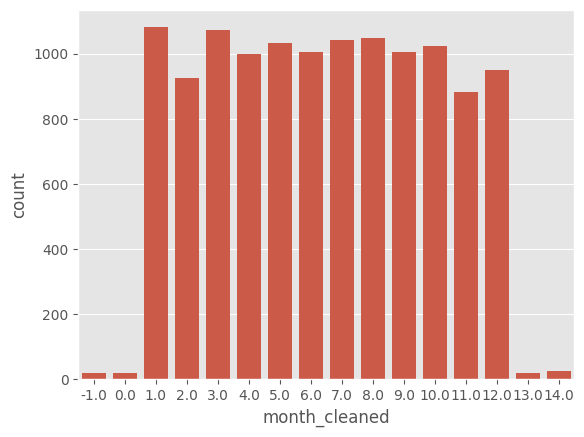

In [62]:
sns.countplot(x='month_cleaned',data=df_temp)

In [63]:
df_temp.loc[df_temp['month_cleaned'] <= 0, 'year_cleaned'] = np.nan
df_temp.loc[df_temp['month_cleaned'] > 12, 'year_cleaned'] = np.nan
df_temp['year_cleaned'].value_counts()

year_cleaned
2023.0    1043
2015.0    1033
2017.0    1029
2016.0    1028
2022.0    1027
2020.0    1023
2018.0    1019
2021.0    1003
2024.0    1001
2019.0     995
2025.0     813
1900.0      42
1850.0      36
2014.0       7
2013.0       4
2012.0       1
2011.0       1
Name: count, dtype: int64

In [64]:
df_temp['week_cleaned'] =  (
    df_temp['week']
    .str.lower()
    .str.replace(' ','')
    .str.strip()
    .str.replace('\t','')
)

/tmp/ipykernel_110/3813981083.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['week_cleaned'] =  (


In [65]:
df_temp['week_cleaned'] = pd.to_numeric(df_temp['week'], errors='coerce')

/tmp/ipykernel_110/1275986122.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['week_cleaned'] = pd.to_numeric(df_temp['week'], errors='coerce')


In [66]:
df_temp['week_cleaned'] = df_temp['week_cleaned'].round()
df_temp[df_temp['week_cleaned'] > 53]

/tmp/ipykernel_110/355140207.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['week_cleaned'] = df_temp['week_cleaned'].round()


,date,year,month,week,date_cleaned,year_cleaned,month_cleaned,week_cleaned
15,09-Feb-2025,2025.0,2.0,60,NaT,2025.0,2.0,60.0
93,10-16-2022\t,2022.0,NaN,54,NaT,2022.0,NaN,54.0
232,20211017,2021.0,10.0,54,NaT,2021.0,10.0,54.0
241,10.07.2016,2016.0,7.0,55,NaT,2016.0,7.0,55.0
599,09/08/2020,NaN,8.0,60,NaT,NaN,8.0,60.0
...,...,...,...,...,...,...,...,...
11873,14/03/2021,2021.0,3.0,60,NaT,2021.0,3.0,60.0
12003,20200524,2020.0,5.0,60,NaT,2020.0,5.0,60.0
12179,21-Feb-2021,NaN,NaN,60,NaT,NaN,NaN,60.0
12529,736442,2017.0,4.0,60,NaT,2017.0,4.0,60.0


<Axes: xlabel='week_cleaned', ylabel='count'>

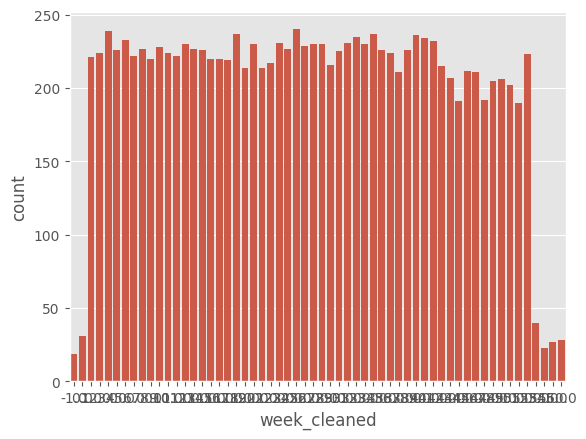

In [67]:
sns.countplot(x='week_cleaned',data=df_temp)

In [68]:
df_temp.loc[df_temp['week_cleaned'] <= 0, 'week_cleaned'] = np.nan
df_temp.loc[df_temp['week_cleaned'] > 53, 'week_cleaned'] = np.nan
df_temp['week_cleaned'].value_counts()

week_cleaned
25.0    240
3.0     239
18.0    237
34.0    237
39.0    236
32.0    235
40.0    234
5.0     233
41.0    232
23.0    231
31.0    231
20.0    230
12.0    230
27.0    230
28.0    230
33.0    230
26.0    229
9.0     228
7.0     227
24.0    227
13.0    227
35.0    226
38.0    226
14.0    226
4.0     226
30.0    225
10.0    224
36.0    224
2.0     224
52.0    223
6.0     222
11.0    222
1.0     221
8.0     220
15.0    220
16.0    220
17.0    219
22.0    217
29.0    216
42.0    215
21.0    214
19.0    214
45.0    212
37.0    211
46.0    211
43.0    207
49.0    206
48.0    205
50.0    202
47.0    192
44.0    191
51.0    190
53.0     40
Name: count, dtype: int64

## Climate Indicator Columns

- temperature_celsius	Float	Average weekly temperature	-21°C to 38°C
- temp_anomaly_celsius	Float	Temperature deviation	Varies
- precipitation_mm	Float	Weekly precipitation	0-200+ mm
- heat_wave_days	Integer	Days with extreme heat	0-7
- drought_indicator	Binary	Drought present	0 or 1
- flood_indicator	Binary	Flooding present	0 or 1
- extreme_weather_events	Integer	Total extreme events	0-10+

In [69]:
climate_cols = ['temperature_celsius','temp_anomaly_celsius','precipitation_mm',
               'heat_wave_days','drought_indicator','flood_indicator','extreme_weather_events']
df_clim = df[climate_cols]

In [70]:
df_clim.head()

,temperature_celsius,temp_anomaly_celsius,precipitation_mm,heat_wave_days,drought_indicator,flood_indicator,extreme_weather_events
0,6.8,0.52,49.5,0.0,0.0,0.0,0.0
1,63.032,-0.31,153.7,0.0,0.0,0.0,0.0
2,3.51,-0.97,51.1,0.0,0.0,0.0,0.0
3,NaN,0.76,18.2,0.0,0.0,0.0,0.0
4,NaN,0.12,134.5,0.0,0.0,NaN,0.0


### temperature_celsius

In [71]:
df_clim['temperature_celsius'].value_counts()

temperature_celsius
-999.0                34
error                 16
999.0                 13
-                     13
#VALUE!               11
                      ..
26.772221107577234     1
19.92417529566697      1
4.880111053905726      1
66.29382009003669      1
1.999143917978626      1
Name: count, Length: 5157, dtype: int64

In [72]:
numeric_version = pd.to_numeric(df_clim['temperature_celsius'], errors='coerce')
    
# Find rows where original had value but numeric conversion failed
string_mask = df_clim['temperature_celsius'].notna() & numeric_version.isna()

In [73]:
df_clim[string_mask]['temperature_celsius'].value_counts()

temperature_celsius
error        16
-            13
--           11
missing      11
#VALUE!      11
#REF!         9
  NA          1
  null        1
#VALUE!\t     1
  #REF!       1
  --          1
  -           1
Name: count, dtype: int64

In [74]:
df_clim['temperature_celsius_cleaned'] = df_clim['temperature_celsius'].astype(str)
df_clim['temperature_celsius_cleaned'] = (
    df_clim['temperature_celsius_cleaned']
    .str.lower()
    .str.strip()
)
invalid_values = [
    'error', '-', '--', 'missing','nan',
    '#value!', '#ref!', 'na', 'null', ''
]
df_clim.loc[
    df_clim['temperature_celsius_cleaned'].isin(invalid_values),
    'temperature_celsius_cleaned'
] = np.nan


/tmp/ipykernel_110/656378728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clim['temperature_celsius_cleaned'] = df_clim['temperature_celsius'].astype(str)
/tmp/ipykernel_110/656378728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clim['temperature_celsius_cleaned'] = (


In [75]:
df_clim['temperature_celsius_cleaned']= pd.to_numeric(df_clim['temperature_celsius_cleaned'])

/tmp/ipykernel_110/3076517814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clim['temperature_celsius_cleaned']= pd.to_numeric(df_clim['temperature_celsius_cleaned'])


In [76]:
df_clim['temperature_celsius_cleaned'].head()

0     6.800
1    63.032
2     3.510
3       NaN
4       NaN
Name: temperature_celsius_cleaned, dtype: float64

<Axes: xlabel='temperature_celsius_cleaned', ylabel='Count'>

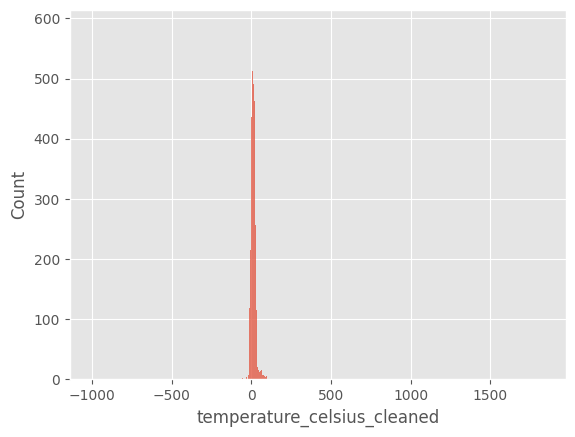

In [77]:
sns.histplot(x=df_clim['temperature_celsius_cleaned'])

In [78]:
# df_clim['temperature_celsius_cleaned'] = df_clim['temperature_celsius_cleaned'].clip(-21,38)

In [79]:
df_clim.loc[df_clim['temperature_celsius_cleaned'] < -21, 'temperature_celsius_cleaned'] = np.nan
df_clim.loc[df_clim['temperature_celsius_cleaned'] > 38, 'temperature_celsius_cleaned'] = np.nan
df_clim['temperature_celsius_cleaned'].value_counts()

temperature_celsius_cleaned
 6.440000     11
 5.270000     10
-1.810000      9
 7.080000      9
 2.450000      9
              ..
 5.375215      1
 16.064522     1
-2.748626      1
 19.129765     1
 7.027824      1
Name: count, Length: 4345, dtype: int64

<Axes: xlabel='temperature_celsius_cleaned', ylabel='Count'>

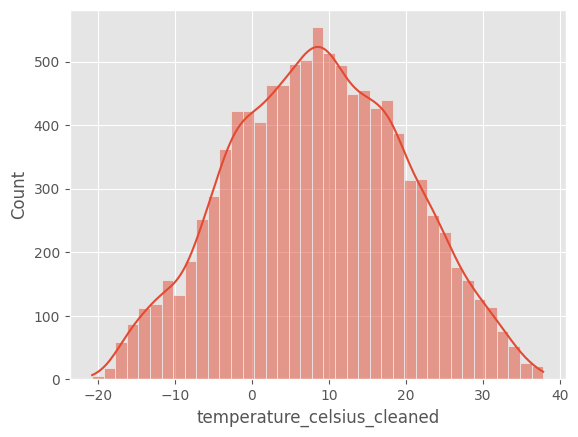

In [80]:
sns.histplot(x=df_clim['temperature_celsius_cleaned'],kde=True)

### temp_anomaly_celsius

In [81]:
df_clim['temp_anomaly_celsius']

0        0.520000
1       -0.310000
2       -0.970000
3        0.760000
4        0.120000
           ...   
12837   -0.279770
12838    0.060049
12839         NaN
12840    0.429023
12841    0.370175
Name: temp_anomaly_celsius, Length: 12842, dtype: float64

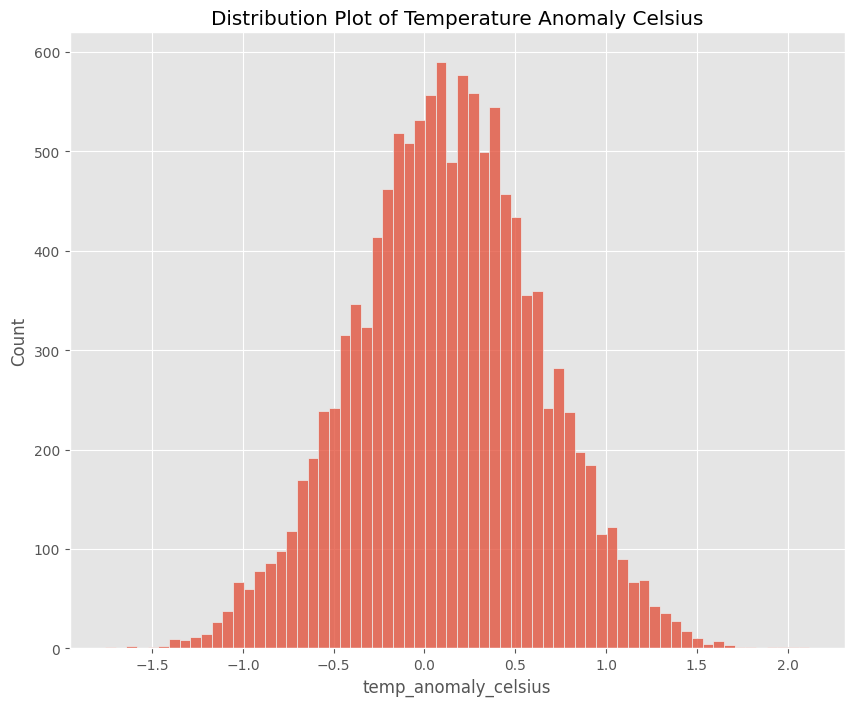

In [82]:
plt.figure(figsize=(10, 8))
sns.histplot(x=df['temp_anomaly_celsius'])
plt.title('Distribution Plot of Temperature Anomaly Celsius')
plt.show()

### precipitation_mm

In [83]:
df_clim['precipitation_mm']

0                      49.5
1                     153.7
2                      51.1
3                      18.2
4                     134.5
                ...        
12837                   NaN
12838    121.76608602771498
12839     81.51308678346338
12840     72.81216357301582
12841    132.43656303945914
Name: precipitation_mm, Length: 12842, dtype: object

In [84]:
df['precipitation_mm'].value_counts().tail(30)

precipitation_mm
117.4                  1
  139.6                1
4.909448818897638      1
78.8\t                 1
176.3                  1
0.9763779527559056     1
  67.6                 1
3.2834645669291342     1
  35.7                 1
131.5                  1
57.6\t                 1
178.6                  1
  94.8                 1
2.8188976377952755     1
  88.2                 1
89.7\t                 1
199.6                  1
75.4\t                 1
-6.043937201383059     1
-20.111965620035292    1
  84.7                 1
5.3                    1
0.3346456692913386     1
  100.6                1
  36.0                 1
4.7                    1
13.9                   1
  122.9                1
  38.7                 1
  41.4                 1
Name: count, dtype: int64

In [85]:
import re

# Keep only numbers, decimal point, and minus sign
df_clim['precipitation_mm_cleaned'] = df_clim['precipitation_mm'].astype(str).str.replace(r'[^\d.-]', '', regex=True)

# Convert to float
df_clim['precipitation_mm_cleaned'] = pd.to_numeric(df_clim['precipitation_mm_cleaned'], errors='coerce')

/tmp/ipykernel_110/1073721273.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clim['precipitation_mm_cleaned'] = df_clim['precipitation_mm'].astype(str).str.replace(r'[^\d.-]', '', regex=True)
/tmp/ipykernel_110/1073721273.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clim['precipitation_mm_cleaned'] = pd.to_numeric(df_clim['precipitation_mm_cleaned'], errors='coerce')


In [86]:
 df_clim[df_clim['precipitation_mm_cleaned'] < 0]

,temperature_celsius,temp_anomaly_celsius,precipitation_mm,heat_wave_days,drought_indicator,flood_indicator,extreme_weather_events,temperature_celsius_cleaned,precipitation_mm_cleaned
10,11.27,0.970000,-60.2559322117588,0.0,N,0.0,0.0,11.270000,-60.255932
840,-2.03,0.540000,-5.241524976238438,0.0,0.0,N,NaN,-2.030000,-5.241525
903,24.3,-0.480000,-81.74090553953495,0.0,NaN,0.0,0.0,24.300000,-81.740906
943,10.66,0.280000,-3.410983052771797,0.0,N,0.0,0.0,10.660000,-3.410983
964,9.36,-0.640000,-80.39176120806849,0.0,0.0,0.0,0.0,9.360000,-80.391761
...,...,...,...,...,...,...,...,...,...
11777,-2.97,0.290000,-87.07064155222737,1.0,0.0,0.0,1.0,-2.970000,-87.070642
11974,-9.17,0.100000,-78.95635257214501,0.0,0.0,0.0,0.0,-9.170000,-78.956353
12284,15.94,0.130000,-14.11216927865668,0.0,NaN,0.0,0.0,15.940000,-14.112169
12735,10.649483454690387,0.280112,-86.77527421986895,0.0,0.0,0.0,0.0,10.649483,-86.775274


### heat_wave_days

In [87]:
df_clim['heat_wave_days'].value_counts()

heat_wave_days
0.000000    10747
1.000000     1044
2.000000      274
3.000000       53
4.000000        9
5.000000        1
1.997331        1
0.998698        1
1.002217        1
1.001093        1
1.997709        1
2.997229        1
0.999326        1
0.999860        1
0.998857        1
0.999319        1
0.997587        1
1.000400        1
2.002725        1
0.999267        1
1.997635        1
1.000793        1
1.000842        1
Name: count, dtype: int64

In [88]:
df_clim['heat_wave_days_round']=df_clim['heat_wave_days'].round()
df_clim['heat_wave_days_round'].value_counts()

/tmp/ipykernel_110/3880241857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clim['heat_wave_days_round']=df_clim['heat_wave_days'].round()


heat_wave_days_round
0.0    10747
1.0     1056
2.0      278
3.0       54
4.0        9
5.0        1
Name: count, dtype: int64

<Axes: xlabel='heat_wave_days_round', ylabel='count'>

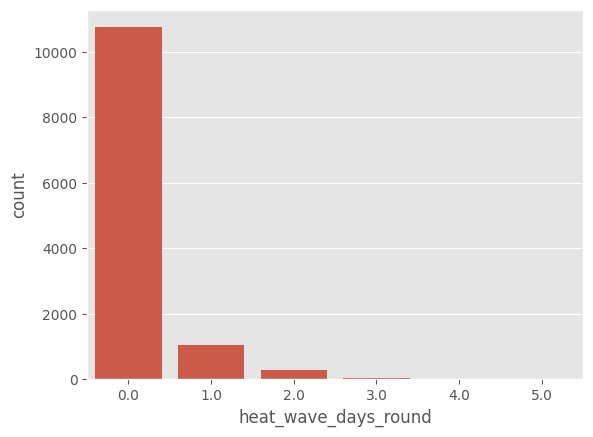

In [89]:
sns.countplot(x='heat_wave_days_round',data=df_clim)

### drought_indicator

In [90]:
df_clim['drought_indicator'].value_counts()

drought_indicator
0.0                   10777
False                   172
N                       165
No                      165
no                      164
FALSE                   161
0                       151
1.0                     133
1                         3
TRUE                      2
Yes                       1
Y                         1
yes                       1
True                      1
1.0000321483312822        1
0.999085341107566         1
1.0001426094682164        1
Name: count, dtype: int64

In [91]:
df_clim['drought_indicator_cleaned'] = (
    df_clim['drought_indicator']
    .str.lower()
    .str.strip()
)
df_clim['drought_indicator_cleaned'].value_counts()

/tmp/ipykernel_110/4291237911.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clim['drought_indicator_cleaned'] = (


drought_indicator_cleaned
0.0                   10777
false                   333
no                      329
n                       165
0                       151
1.0                     133
1                         3
true                      3
yes                       2
y                         1
1.0000321483312822        1
0.999085341107566         1
1.0001426094682164        1
Name: count, dtype: int64

In [92]:
drought_map = {
    # 0
    'false': 0,
    'n': 0,
    'no': 0,
    'n': 0,


    # 1
    'true': 1,
    'yes': 1,
    'y': 1,
}

df_clim['drought_indicator_cleaned'] = df_clim['drought_indicator_cleaned'].replace(drought_map)

df_clim['drought_indicator_cleaned'] =pd.to_numeric(df_clim['drought_indicator_cleaned'])

df_clim['drought_indicator_cleaned']= df_clim['drought_indicator_cleaned'].round()

df_clim['drought_indicator_cleaned'].value_counts()

/tmp/ipykernel_110/2580353246.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clim['drought_indicator_cleaned'] = df_clim['drought_indicator_cleaned'].replace(drought_map)
/tmp/ipykernel_110/2580353246.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clim['drought_indicator_cleaned'] =pd.to_numeric(df_clim['drought_indicator_cleaned'])
/tmp/ipykernel_110/2580353246.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

drought_indicator_cleaned
0.0    11755
1.0      145
Name: count, dtype: int64

In [93]:
df_clim['drought_indicator'].isna().sum()

np.int64(942)

<Axes: xlabel='drought_indicator_cleaned', ylabel='count'>

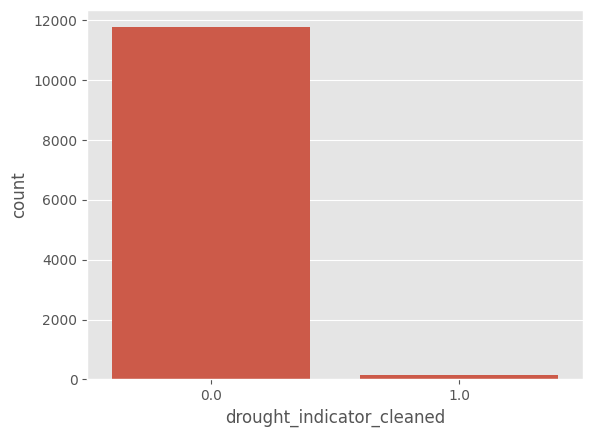

In [94]:
sns.countplot(x='drought_indicator_cleaned',data=df_clim)

### flood_indicator

In [95]:
df['flood_indicator'].value_counts()

flood_indicator
0.0      10556
FALSE      178
N          167
False      167
no         162
No         160
0          152
1.0         58
Yes          1
Y            1
True         1
yes          1
Name: count, dtype: int64

In [96]:
df_clim['flood_indicator_cleaned'] = (
    df_clim['flood_indicator']
    .str.lower()
    .str.strip()
)
df_clim['flood_indicator_cleaned'].value_counts()

/tmp/ipykernel_110/318318502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clim['flood_indicator_cleaned'] = (


flood_indicator_cleaned
0.0      10556
false      345
no         322
n          167
0          152
1.0         58
yes          2
y            1
true         1
Name: count, dtype: int64

In [97]:
flood_map = {
    # 0
    'false': 0,
    'n': 0,
    'no': 0,
    
    # 1
    'true': 1,
    'yes': 1,
    'y': 1,
}

df_clim['flood_indicator_cleaned'] = df_clim['flood_indicator_cleaned'].replace(flood_map)

df_clim['flood_indicator_cleaned'] =pd.to_numeric(df_clim['flood_indicator_cleaned'])

df_clim['flood_indicator_cleaned']= df_clim['flood_indicator_cleaned'].round()

df_clim['flood_indicator_cleaned'].value_counts()

/tmp/ipykernel_110/2852420528.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clim['flood_indicator_cleaned'] = df_clim['flood_indicator_cleaned'].replace(flood_map)
/tmp/ipykernel_110/2852420528.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clim['flood_indicator_cleaned'] =pd.to_numeric(df_clim['flood_indicator_cleaned'])
/tmp/ipykernel_110/2852420528.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

flood_indicator_cleaned
0.0    11542
1.0       62
Name: count, dtype: int64

<Axes: xlabel='flood_indicator_cleaned', ylabel='count'>

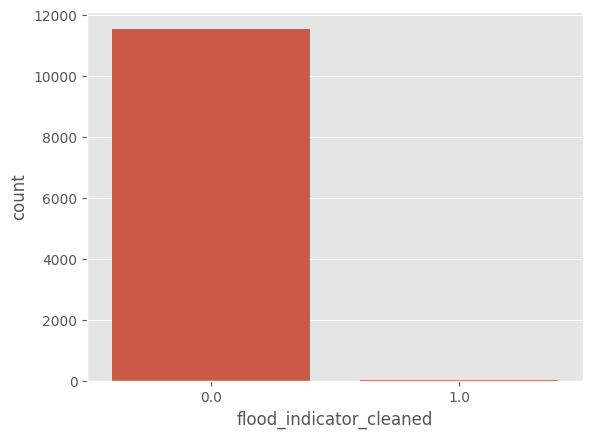

In [98]:
sns.countplot(x='flood_indicator_cleaned',data=df_clim)

### extreme_weather_events

In [99]:
df['extreme_weather_events'].value_counts()

extreme_weather_events
0.000000    10604
1.000000     1208
2.000000      288
3.000000       62
4.000000       12
5.000000        1
1.000613        1
1.999915        1
0.998860        1
0.998715        1
0.998953        1
0.999447        1
1.000591        1
2.002742        1
3.001961        1
1.000437        1
1.001206        1
1.001383        1
0.999916        1
0.997838        1
0.999410        1
0.999617        1
1.998218        1
1.997400        1
1.001362        1
1.995687        1
1.000492        1
Name: count, dtype: int64

In [100]:
df_clim['extreme_weather_events_round'] = df_clim['extreme_weather_events'].round()
df_clim['extreme_weather_events_round'].value_counts()

/tmp/ipykernel_110/2573895986.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clim['extreme_weather_events_round'] = df_clim['extreme_weather_events'].round()


extreme_weather_events_round
0.0    10604
1.0     1223
2.0      293
3.0       63
4.0       12
5.0        1
Name: count, dtype: int64

<Axes: xlabel='extreme_weather_events_round', ylabel='count'>

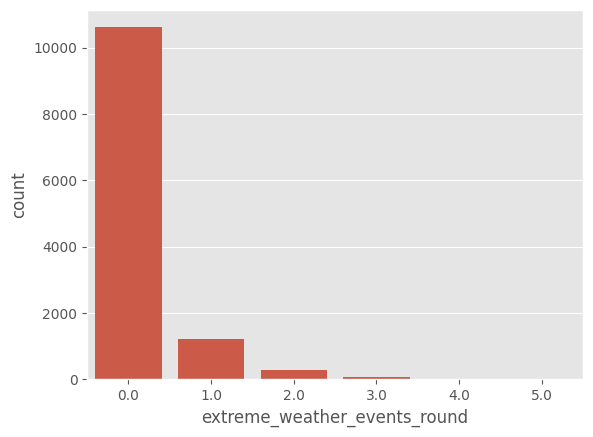

In [101]:
sns.countplot(x='extreme_weather_events_round',data=df_clim)

<Axes: xlabel='extreme_weather_events_round', ylabel='heat_wave_days_round'>

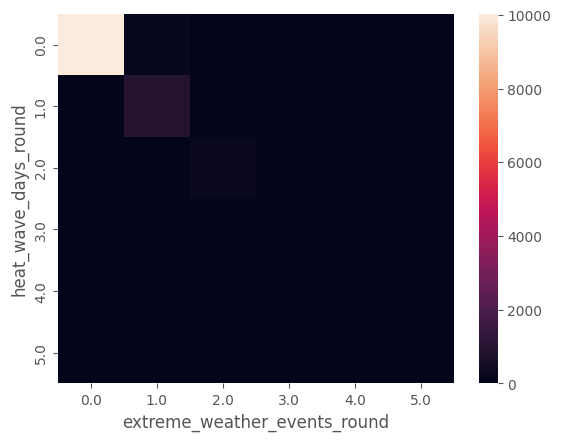

In [102]:
sns.heatmap(pd.crosstab(df_clim['heat_wave_days_round'],df_clim['extreme_weather_events_round']))

In [103]:
df_clim['heat_wave_days_round'].corr(df_clim['extreme_weather_events_round']) #high correlations

np.float64(0.9618505320228224)

## Air Quality Columns

- pm25_ugm3	Float	PM2.5 concentration (μg/m³)	WHO guideline: 5 μg/m³
- air_quality_index	Float	Overall AQI (0-500)	0-50 Good, 51-100 Moderate

In [104]:
air_qual_cols = ['pm25_ugm3','air_quality_index']
df_air = df[air_qual_cols]
df_air

,pm25_ugm3,air_quality_index
0,93.3,138.000000
1,NaN,175.000000
2,111.6,176.000000
3,81.1,123.000000
4,114.2,159.000000
...,...,...
12837,30.417813757784426,58.933215
12838,67.20231403405994,123.038012
12839,150.61896174967887,248.724519
12840,53.5857994332107,103.016729


### pm25_ugm3

pm25_ugm3 breaks down as follows:
<br>
PM2.5 = Particulate Matter 2.5<br>
ugm3 = micrograms per cubic meter (μg/m³)<br>

0-12 μg/m³: Good air quality <br>
12-35 μg/m³: Moderate concern<br>
35-55 μg/m³: Unhealthy for sensitive groups<br>
55+ μg/m³: Unhealthy to hazardous<br>

This can be converted into category if required

In [105]:
df_air['pm25_ugm3'].value_counts().tail(20)

pm25_ugm3
37.71252149145565      1
55.60547565841375      1
51.65164868071224      1
75.85666440165198      1
63.21385004359025      1
50.54971174384266      1
128.34773203700686     1
68.64149449253847      1
98.85461007325216      1
58.374942587302684     1
8.285599370694555      1
100.27147194144024     1
75.08592579645706      1
18.986116576042285     1
49.229386652644784     1
29.610616384661583     1
36.24119347546828      1
55.618449524894444     1
20.721367263252283     1
106.83842112093745     1
Name: count, dtype: int64

In [106]:
numeric_version_pm = pd.to_numeric(df_air['pm25_ugm3'], errors='coerce')
    
# Find rows where original had value but numeric conversion failed
string_mask_pm = df_air['pm25_ugm3'].notna() & numeric_version_pm.isna()

df_air[string_mask_pm]['pm25_ugm3'].value_counts()
df_air['pm25_ugm3_cleaned'] = df_air['pm25_ugm3'].astype(str)
df_air['pm25_ugm3_cleaned'] = (
    df_air['pm25_ugm3_cleaned']
    .str.lower()
    .str.strip()
)
invalid_values_pm = [
    'error', '-', '--', 'missing','nan',
    '#value!', '#ref!', 'na', 'null', '','n/a',
    'none'
]
df_air.loc[
    df_air['pm25_ugm3_cleaned'].isin(invalid_values_pm),
    'pm25_ugm3_cleaned'
] = np.nan

/tmp/ipykernel_110/184504274.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['pm25_ugm3_cleaned'] = df_air['pm25_ugm3'].astype(str)
/tmp/ipykernel_110/184504274.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['pm25_ugm3_cleaned'] = (


In [107]:
df_air['pm25_ugm3_cleaned'] = pd.to_numeric(df_air['pm25_ugm3_cleaned'] )

/tmp/ipykernel_110/169338523.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['pm25_ugm3_cleaned'] = pd.to_numeric(df_air['pm25_ugm3_cleaned'] )


In [108]:
df_air['pm25_ugm3_cleaned']

0         93.300000
1               NaN
2        111.600000
3         81.100000
4        114.200000
            ...    
12837     30.417814
12838     67.202314
12839    150.618962
12840     53.585799
12841     84.057857
Name: pm25_ugm3_cleaned, Length: 12842, dtype: float64

<Axes: xlabel='pm25_ugm3_cleaned', ylabel='Count'>

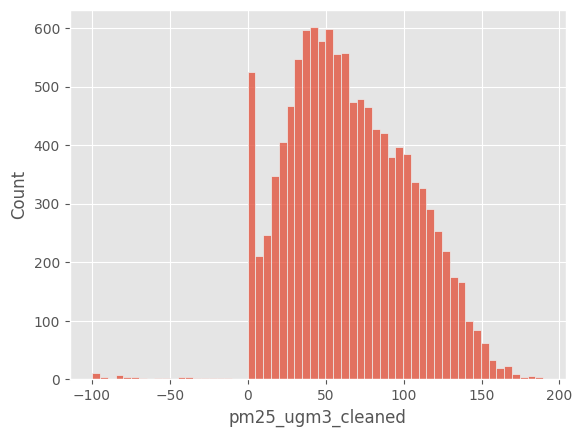

In [109]:
sns.histplot(df_air['pm25_ugm3_cleaned'])

In [110]:
df_air.loc[df_air['pm25_ugm3_cleaned'] < 0, 'pm25_ugm3_cleaned'] = np.nan
df_air['pm25_ugm3_cleaned'].value_counts()

pm25_ugm3_cleaned
0.000000      341
46.900000      22
45.300000      22
41.300000      21
34.100000      20
             ... 
37.712521       1
55.618450       1
20.721367       1
106.838421      1
63.213850       1
Name: count, Length: 1759, dtype: int64

<Axes: xlabel='pm25_ugm3_cleaned', ylabel='Count'>

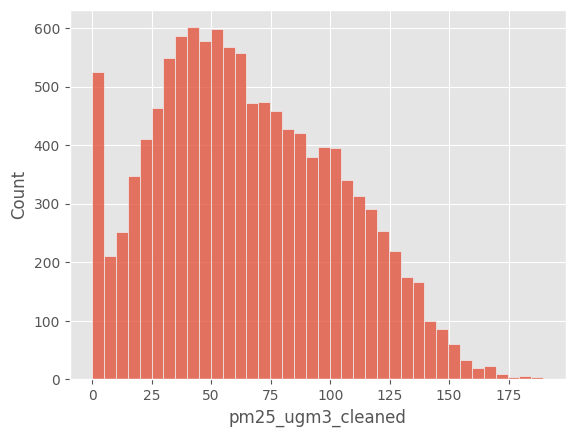

In [111]:
sns.histplot(df_air['pm25_ugm3_cleaned'])

### air_quality_index

In [112]:
df_air['air_quality_index']

0        138.000000
1        175.000000
2        176.000000
3        123.000000
4        159.000000
            ...    
12837     58.933215
12838    123.038012
12839    248.724519
12840    103.016729
12841           NaN
Name: air_quality_index, Length: 12842, dtype: float64

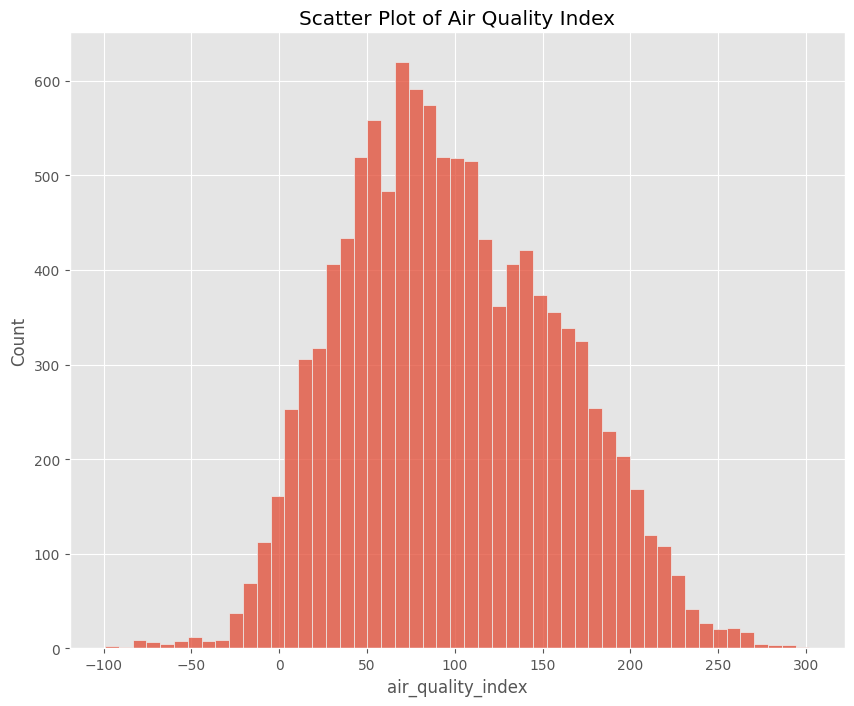

In [113]:
plt.figure(figsize=(10, 8))
sns.histplot(x=df_air['air_quality_index'])
plt.title('Scatter Plot of Air Quality Index')
plt.show()

In [114]:
df_air.loc[df_air['air_quality_index'] < 0, 'air_quality_index'] = np.nan
df_air['air_quality_index'].value_counts()

air_quality_index
69.000000     97
80.000000     93
45.000000     84
62.000000     84
72.000000     81
              ..
113.931007     1
58.933215      1
123.038012     1
248.724519     1
103.016729     1
Name: count, Length: 437, dtype: int64

/tmp/ipykernel_110/3328630052.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['air_quality_index_before'] = df[['air_quality_index']]


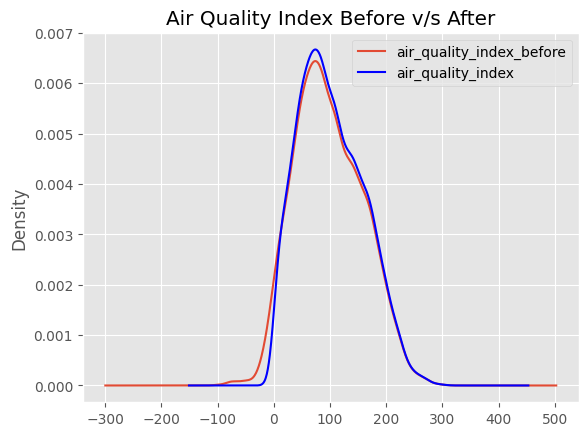

In [115]:

fig = plt.figure()
ax = fig.add_subplot(111)
df_air['air_quality_index_before'] = df[['air_quality_index']]
df_air['air_quality_index_before'].plot(kind='kde', ax=ax)
df_air['air_quality_index'].plot(kind='kde', ax=ax, color='blue')
plt.title('Air Quality Index Before v/s After')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

## Socioeconomic & Wellbeing Columns


- healthcare_access_index	Float	Healthcare accessibility	0-100
- gdp_per_capita_usd	Float	GDP per capita in USD	Varies
- mental_health_index	Float	Mental health score	0-100
- food_security_index	Float	Food security score	0-100

In [116]:
socio_cols = ['healthcare_access_index','gdp_per_capita_usd','mental_health_index','food_security_index']
df_socio = df[socio_cols]
df_socio

,healthcare_access_index,gdp_per_capita_usd,mental_health_index,food_security_index
0,50.700000,2700.000000,NaN,NaN
1,41.100000,4174.000000,70.600000,NaN
2,48.900000,2606.000000,67.100000,NaN
3,69.100000,NaN,69.500000,100.000000
4,46.300000,2963.000000,73.600000,96.100000
...,...,...,...,...
12837,NaN,75120.172318,72.561534,NaN
12838,36.556269,2675.183604,64.470222,NaN
12839,34.013486,2772.915205,71.597020,92.237572
12840,NaN,3913.487327,63.588121,83.689264


### healthcare_access_index 

In [117]:
df_socio['healthcare_access_index'].describe()

count    8554.000000
mean       64.842716
std        18.244755
min        28.100000
25%        46.900000
50%        66.250000
75%        81.600000
max       102.000000
Name: healthcare_access_index, dtype: float64

As we can see, the range is 0 to 100, but we have max values of 100. So we will cap those to 100.

In [118]:
df_socio['healthcare_access_index'] = df_socio['healthcare_access_index'].clip(0,100)
df_socio['healthcare_access_index'].describe()

/tmp/ipykernel_110/3858003060.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_socio['healthcare_access_index'] = df_socio['healthcare_access_index'].clip(0,100)


count    8554.000000
mean       64.842213
std        18.243761
min        28.100000
25%        46.900000
50%        66.250000
75%        81.600000
max       100.000000
Name: healthcare_access_index, dtype: float64

### gdp_per_capita_usd

In [119]:
df_socio['gdp_per_capita_usd']

0         2700.000000
1         4174.000000
2         2606.000000
3                 NaN
4         2963.000000
             ...     
12837    75120.172318
12838     2675.183604
12839     2772.915205
12840     3913.487327
12841     2731.559250
Name: gdp_per_capita_usd, Length: 12842, dtype: float64

In [120]:
df_socio['gdp_per_capita_usd'].describe()

count    11878.000000
mean     26134.737760
std      26315.881181
min        -99.732182
25%       3528.153901
50%      13796.094953
75%      49965.000000
max      78630.000000
Name: gdp_per_capita_usd, dtype: float64

We see that the value is going negative (not possible i.e can be near zero but never negative) since gdp is total_gdp / population and total_gdp is not negative even in very critical crisis.

In [121]:
df_socio[df_socio['gdp_per_capita_usd'] < 0]

,healthcare_access_index,gdp_per_capita_usd,mental_health_index,food_security_index
543,42.6,-71.590493,70.3,91.0
802,86.5,-84.804712,NaN,NaN
807,NaN,-73.723934,79.7,90.2
813,64.1,-25.074615,70.4,NaN
814,81.7,-23.125846,NaN,93.1
...,...,...,...,...
11652,NaN,-85.651359,NaN,NaN
11845,47.1,-77.852741,78.5,91.8
12293,NaN,-16.462850,75.7,94.2
12455,NaN,-73.723934,79.7,90.2


In [122]:
df_socio.hist

<bound method hist_frame of        healthcare_access_index  gdp_per_capita_usd  mental_health_index  \
0                    50.700000         2700.000000                  NaN   
1                    41.100000         4174.000000            70.600000   
2                    48.900000         2606.000000            67.100000   
3                    69.100000                 NaN            69.500000   
4                    46.300000         2963.000000            73.600000   
...                        ...                 ...                  ...   
12837                      NaN        75120.172318            72.561534   
12838                36.556269         2675.183604            64.470222   
12839                34.013486         2772.915205            71.597020   
12840                      NaN         3913.487327            63.588121   
12841                      NaN         2731.559250            59.956663   

       food_security_index  
0                      NaN  
1            

In [123]:
df_socio['gdp_per_capita_usd'] = df_socio['gdp_per_capita_usd'].abs()

/tmp/ipykernel_110/1936125184.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_socio['gdp_per_capita_usd'] = df_socio['gdp_per_capita_usd'].abs()


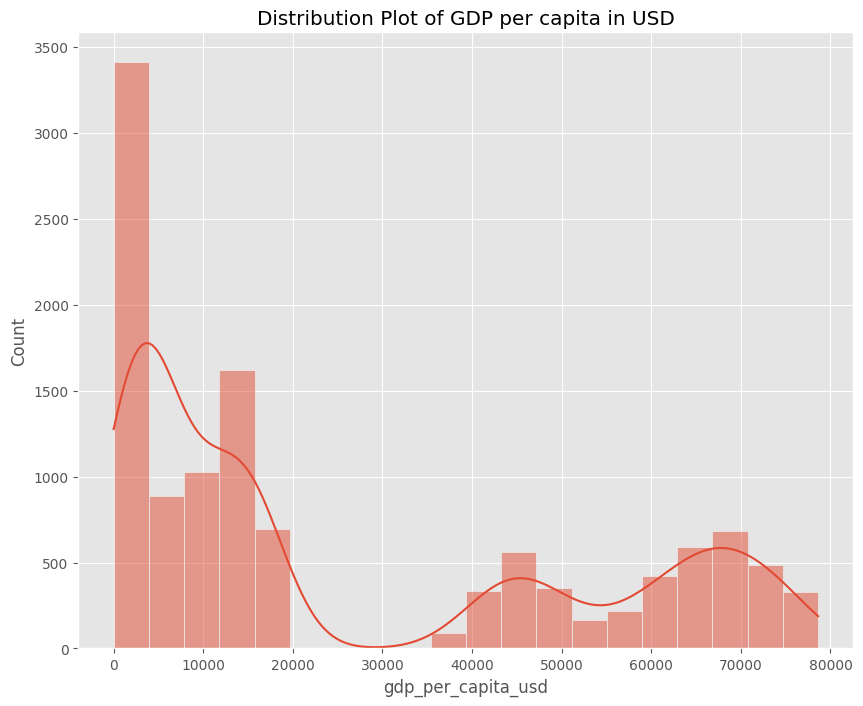

In [124]:
plt.figure(figsize=(10, 8))
sns.histplot(x=df_socio['gdp_per_capita_usd'],kde=True)
plt.title('Distribution Plot of GDP per capita in USD')
plt.show()

### mental_health_index

In [125]:
df_socio['mental_health_index'].describe()

count    9126.000000
mean       69.866467
std         5.021787
min        47.700000
25%        66.500000
50%        70.000000
75%        73.300000
max        88.700000
Name: mental_health_index, dtype: float64

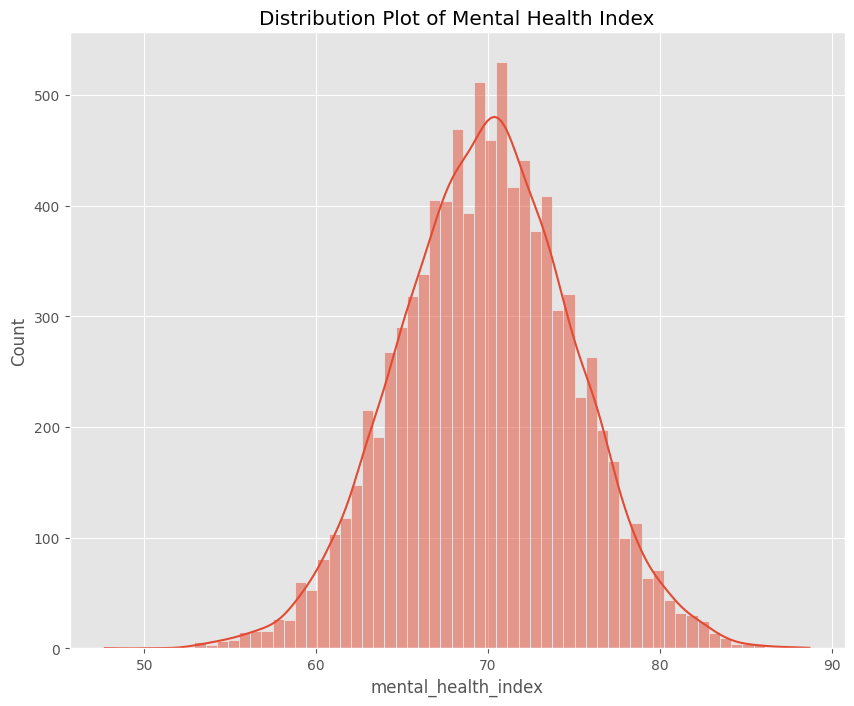

In [126]:
plt.figure(figsize=(10, 8))
sns.histplot(x=df['mental_health_index'],kde=True)
plt.title('Distribution Plot of Mental Health Index')
plt.show()

### food_security_index

In [127]:
df_socio['food_security_index'].describe()

count    8060.000000
mean       93.395165
std         6.298881
min        65.300000
25%        88.900000
50%        94.600000
75%        99.900000
max       100.177448
Name: food_security_index, dtype: float64

In [128]:
df_socio['food_security_index'] = df_socio['food_security_index'].abs()

/tmp/ipykernel_110/1425068846.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_socio['food_security_index'] = df_socio['food_security_index'].abs()


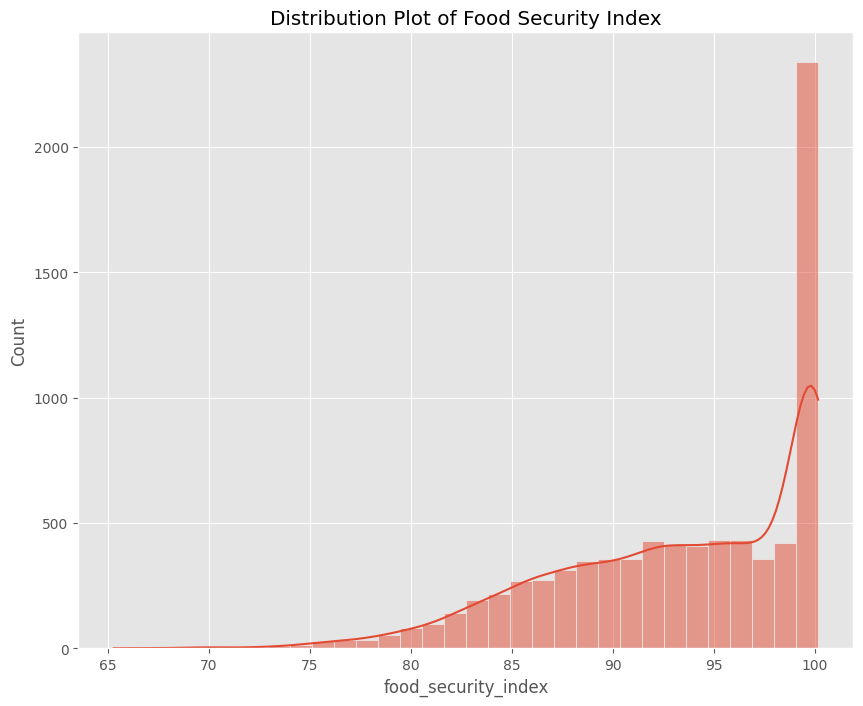

In [129]:
plt.figure(figsize=(10, 8))
sns.histplot(x=df['food_security_index'],kde=True)
plt.title('Distribution Plot of Food Security Index')
plt.show()

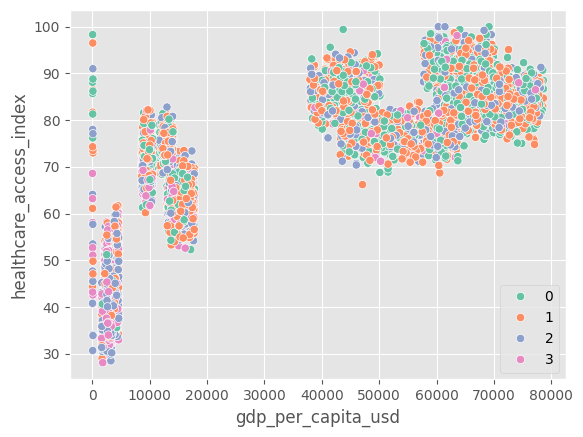

In [130]:
sns.scatterplot(x=df_socio['gdp_per_capita_usd'],y=df_socio['healthcare_access_index'],hue=df['health_risk_class'],palette='Set2')
plt.legend()

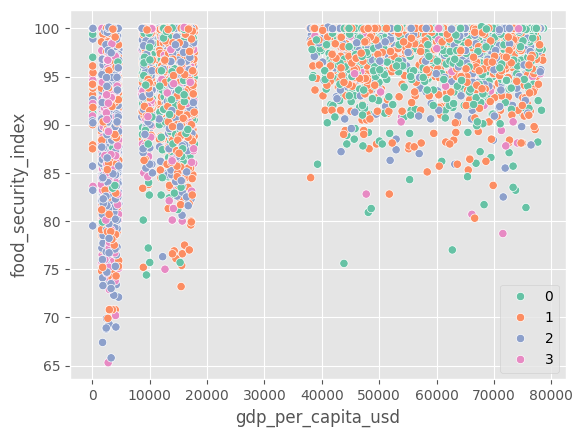

In [131]:
sns.scatterplot(x=df_socio['gdp_per_capita_usd'],y=df_socio['food_security_index'],hue=df['health_risk_class'],palette='Set2')
plt.legend()

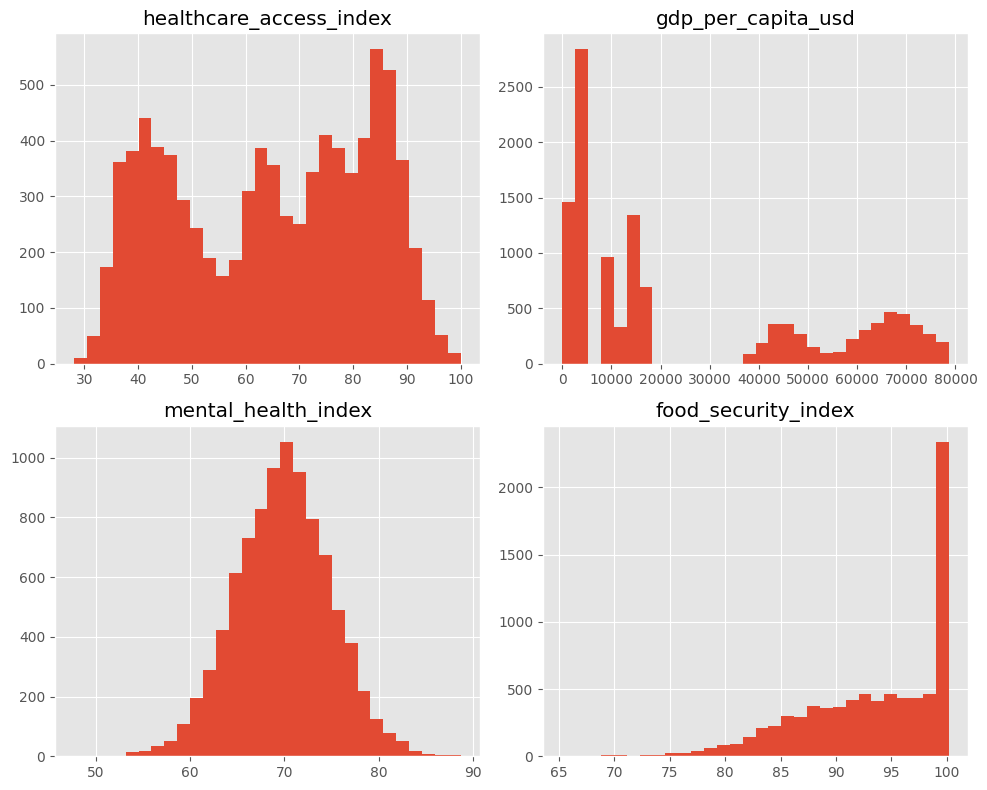

In [132]:
df_socio.hist(bins=30, figsize=(10, 8))
# pd.DataFrame(X_train_num_imputed,columns=num_cols).hist(bins=30, figsize=(15, 10),color='blue')
plt.tight_layout()
plt.show()

## Train Test Split

In [133]:
df_socio.columns

Index(['healthcare_access_index', 'gdp_per_capita_usd', 'mental_health_index',
       'food_security_index'],
      dtype='object')

In [134]:
#columns used from each subtype
geo_cleaned_cols = ['latitude','longitude',
                  'income_level_cleaned',
                  'population_millions_cleaned','region_cleaned',
                   'country_name_cleaned','country_code_cleaned']
temp_cleaned_cols = ['year_cleaned','month_cleaned','week_cleaned']

clim_cleaned_cols = ['temperature_celsius_cleaned','temp_anomaly_celsius',
               'precipitation_mm_cleaned', 'heat_wave_days_round',
                'drought_indicator_cleaned',
               'flood_indicator_cleaned', 'extreme_weather_events_round']

air_cleaned_cols = ['air_quality_index', 'pm25_ugm3_cleaned']

socio_cleaned_cols = ['gdp_per_capita_usd', 'mental_health_index',
       'food_security_index','healthcare_access_index']

In [135]:
X = pd.concat([
    df_geo[geo_cleaned_cols],
    df_clim[clim_cleaned_cols],
    df_air[air_cleaned_cols],
    df_socio[socio_cleaned_cols],
    df_temp[temp_cleaned_cols]
], axis=1) 

y = df['health_risk_class']

In [136]:
X

,latitude,longitude,income_level_cleaned,population_millions_cleaned,region_cleaned,country_name_cleaned,country_code_cleaned,temperature_celsius_cleaned,temp_anomaly_celsius,precipitation_mm_cleaned,heat_wave_days_round,drought_indicator_cleaned,flood_indicator_cleaned,extreme_weather_events_round,air_quality_index,pm25_ugm3_cleaned,gdp_per_capita_usd,mental_health_index,food_security_index,healthcare_access_index,year_cleaned,month_cleaned,week_cleaned
0,20.590000,78.960000,lower-middle,NaN,south asia,india,ind,6.800000,0.520000,49.500000,0.0,0.0,0.0,0.0,138.000000,93.300000,2700.000000,NaN,NaN,50.700000,2019.0,9.0,39.0
1,26.820000,30.800000,lower-middle,102.000000,africa,egypt,egy,NaN,-0.310000,153.700000,0.0,0.0,0.0,0.0,175.000000,NaN,4174.000000,70.600000,NaN,41.100000,2020.0,3.0,11.0
2,20.590000,78.960000,lower-middle,1380.000000,south asia,india,ind,3.510000,-0.970000,51.100000,0.0,0.0,0.0,0.0,176.000000,111.600000,2606.000000,67.100000,NaN,48.900000,2017.0,10.0,40.0
3,35.860000,104.190000,upper-middle,1411.000000,east asia,china,chn,NaN,0.760000,18.200000,0.0,0.0,0.0,0.0,123.000000,81.100000,NaN,69.500000,100.000000,69.100000,2016.0,8.0,33.0
4,20.590000,78.960000,lower-middle,1380.000000,south asia,india,ind,NaN,0.120000,134.500000,0.0,0.0,NaN,0.0,159.000000,114.200000,2963.000000,73.600000,96.100000,46.300000,2025.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12837,37.103984,-95.706166,high,330.943842,north america,united states,usa,NaN,-0.279770,NaN,0.0,0.0,NaN,0.0,58.933215,30.417814,75120.172318,72.561534,NaN,NaN,NaN,2.0,5.0
12838,9.078910,8.665646,lower-middle,206.049171,africa,nigeria,nga,24.859430,0.060049,121.766086,0.0,0.0,0.0,0.0,123.038012,67.202314,2675.183604,64.470222,NaN,36.556269,2024.0,2.0,NaN
12839,202.033983,8.675336,lower-middle,205.848811,sub-saharan africa,nigeria,nga,27.771405,NaN,81.513087,1.0,0.0,0.0,1.0,248.724519,150.618962,2772.915205,71.597020,92.237572,34.013486,2024.0,4.0,15.0
12840,NaN,69.313764,lower-middle,225.029879,south asia,pakistan,pak,-0.059955,0.429023,72.812164,0.0,0.0,0.0,0.0,103.016729,53.585799,3913.487327,63.588121,83.689264,NaN,2016.0,11.0,44.0


In [137]:
y

0        1
1        2
2        1
3        1
4        1
        ..
12837    1
12838    3
12839    3
12840    0
12841    2
Name: health_risk_class, Length: 12842, dtype: int64

In [138]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [139]:
X_train.shape,X_test.shape

((10273, 23), (2569, 23))

In [140]:
# ordinal encoding income_level_cleaned
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler

In [141]:
ordinal_features = ['income_level_cleaned']

categories = [
    ['lower-middle','upper-middle','high']
]

encoder = OrdinalEncoder(categories=categories,handle_unknown='use_encoded_value',unknown_value=-1)

X_train[ordinal_features] = encoder.fit_transform(X_train[ordinal_features])
X_test[ordinal_features] = encoder.transform(X_test[ordinal_features])

In [142]:
X_train['income_level_cleaned'] =X_train['income_level_cleaned'].replace(-1, np.nan)
X_test['income_level_cleaned'] = X_test['income_level_cleaned'].replace(-1, np.nan)

In [143]:
X_train['income_level_cleaned'].value_counts()

income_level_cleaned
2.0    3543
0.0    3419
1.0    2636
Name: count, dtype: int64

### Frequency Encoding
1. region_cleaned
2. country_name_cleaned
3. country_code_cleaned

In [144]:
freq_cols = ['region_cleaned', 'country_name_cleaned', 'country_code_cleaned']

freq_maps = {}

for col in freq_cols:
    freq = X_train[col].value_counts(normalize=True)
    freq_maps[col] = freq

    X_train[f'{col}_freq'] = X_train[col].map(freq)
    X_test[f'{col}_freq'] = X_test[col].map(freq).fillna(0)


In [145]:
X_train

,latitude,longitude,income_level_cleaned,population_millions_cleaned,region_cleaned,country_name_cleaned,country_code_cleaned,temperature_celsius_cleaned,temp_anomaly_celsius,precipitation_mm_cleaned,heat_wave_days_round,drought_indicator_cleaned,flood_indicator_cleaned,extreme_weather_events_round,air_quality_index,pm25_ugm3_cleaned,gdp_per_capita_usd,mental_health_index,food_security_index,healthcare_access_index,year_cleaned,month_cleaned,week_cleaned,region_cleaned_freq,country_name_cleaned_freq,country_code_cleaned_freq
3570,37.09,-95.71,2.0,331.0,north america,united states,usa,-2.01,0.00,24.7,NaN,0.0,0.0,0.0,87.0,56.7,65745.0,63.0,100.0,78.8,2016.0,9.0,36.0,0.108080,0.031734,0.035627
11537,36.20,138.25,2.0,126.0,east asia,japan,jpn,6.79,0.57,150.3,0.0,0.0,0.0,0.0,35.0,15.0,76022.0,66.4,95.9,81.8,2024.0,5.0,21.0,0.071985,0.033973,0.036406
6057,-25.27,133.77,2.0,NaN,oceania,australia,aus,16.48,0.82,164.4,0.0,0.0,0.0,0.0,53.0,26.7,52050.0,74.1,100.0,78.0,2025.0,4.0,14.0,0.036300,0.034751,0.036601
7920,NaN,2.21,2.0,65.0,europe,france,fra,-0.57,0.44,91.7,0.0,0.0,0.0,0.0,51.0,38.1,63973.0,68.6,97.6,90.2,2018.0,5.0,21.0,0.171760,0.032804,0.034751
777,36.20,138.25,2.0,126.0,east asia,land of the rising sun,jpn,7.72,0.57,110.9,0.0,NaN,0.0,0.0,NaN,39.8,65786.0,NaN,NaN,NaN,2016.0,5.0,19.0,0.071985,0.002142,0.036406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,-0.78,113.92,0.0,274.0,southeast asia,indonesia,idn,26.49,-0.47,129.0,0.0,0.0,NaN,0.0,168.0,107.0,NaN,66.4,NaN,40.6,2025.0,NaN,5.0,0.130947,0.034459,0.038256
5191,15.87,100.99,1.0,70.0,southeast asia,thailand,tha,NaN,-0.83,133.4,2.0,0.0,0.0,2.0,3.0,0.0,17034.0,59.9,93.2,58.6,2023.0,3.0,10.0,0.130947,0.038256,0.039132
5390,-38.41,-63.61,1.0,45.0,south america,argentina,arg,-9.97,0.36,54.8,0.0,0.0,0.0,0.0,128.0,94.2,13185.0,60.8,84.8,NaN,2015.0,9.0,36.0,0.099159,0.038937,0.040202
860,55.37,-3.43,2.0,67.0,europe,united kingdom,gbr,-15.05,-0.24,64.9,0.0,0.0,0.0,0.0,24.0,25.4,63098.0,76.1,NaN,NaN,2019.0,9.0,37.0,0.171760,0.031734,0.036601


### Imputation

In [146]:
X_train.isnull().sum()

latitude                         699
longitude                       1226
income_level_cleaned             675
population_millions_cleaned     1179
region_cleaned                   521
country_name_cleaned               0
country_code_cleaned               0
temperature_celsius_cleaned     1859
temp_anomaly_celsius             610
precipitation_mm_cleaned        1023
heat_wave_days_round             563
drought_indicator_cleaned        765
flood_indicator_cleaned          990
extreme_weather_events_round     512
air_quality_index               1441
pm25_ugm3_cleaned                852
gdp_per_capita_usd               774
mental_health_index             2975
food_security_index             3807
healthcare_access_index         3443
year_cleaned                    1395
month_cleaned                    549
week_cleaned                    1020
region_cleaned_freq              521
country_name_cleaned_freq          0
country_code_cleaned_freq          0
dtype: int64

In [147]:
cat_cols = [
    # 'income_level_cleaned',
            # 'drought_indicator_cleaned','flood_indicator_cleaned',
            'extreme_weather_events_round']
num_cols = ['latitude','longitude','population_millions_cleaned','temperature_celsius_cleaned',
           'temp_anomaly_celsius','precipitation_mm_cleaned',
            'year_cleaned','month_cleaned','week_cleaned',
            # 'air_quality_index',
            'pm25_ugm3_cleaned',
           'gdp_per_capita_usd','mental_health_index','food_security_index',
            'healthcare_access_index',
            'region_cleaned_freq','country_name_cleaned_freq','country_code_cleaned_freq']

In [148]:
from sklearn.impute import SimpleImputer, KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_train_num_imputed= imputer.fit_transform(X_train[num_cols])
X_test_num_imputed = imputer.transform(X_test[num_cols])

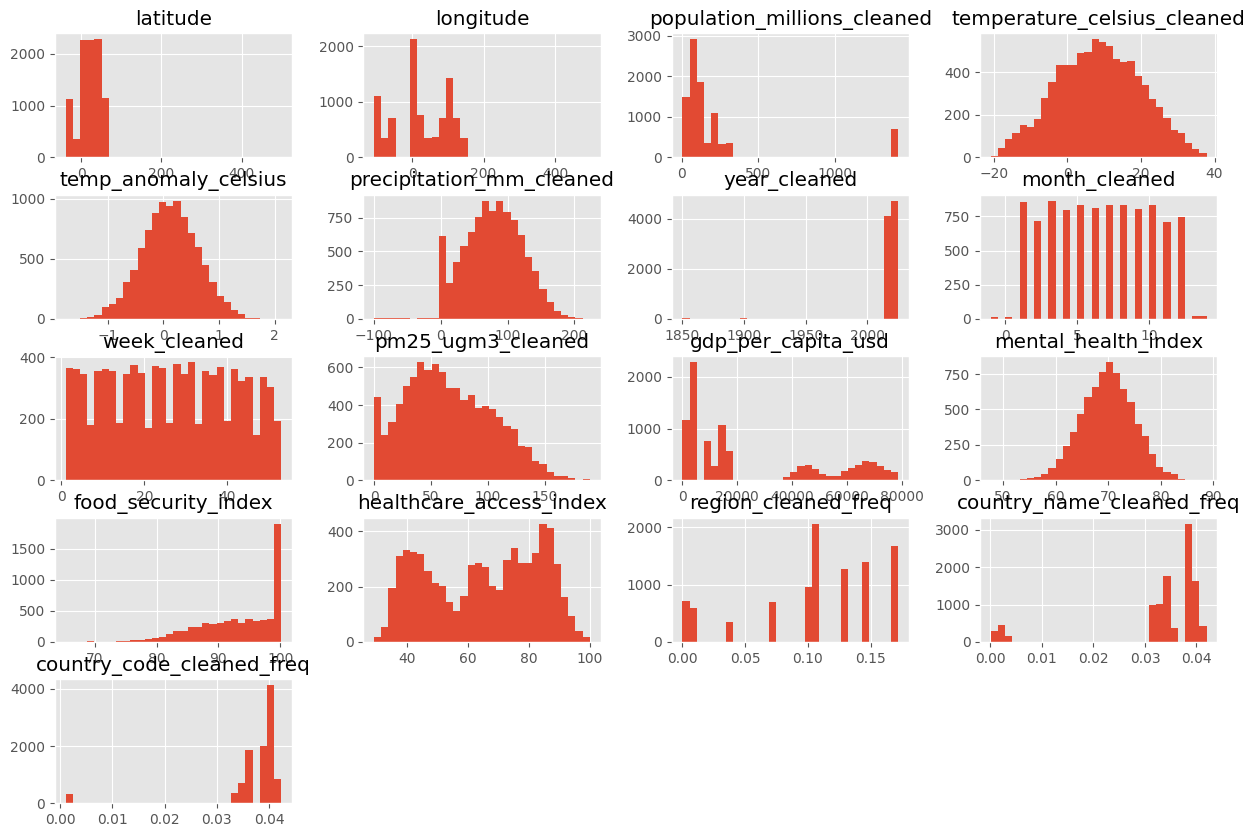

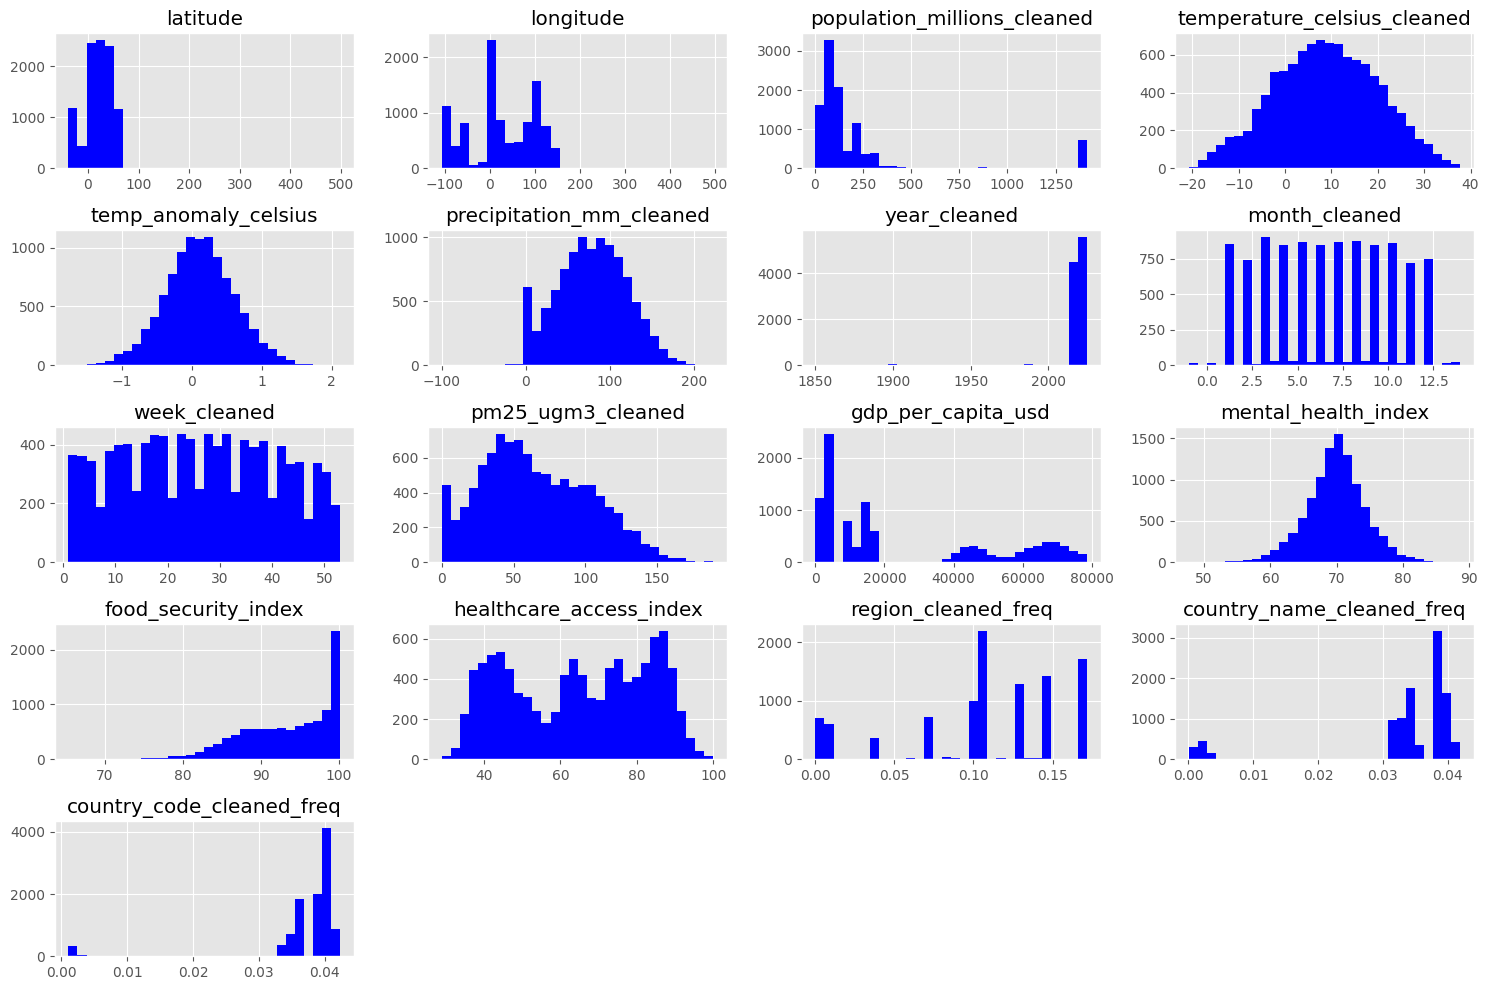

In [149]:
X_train[num_cols].hist(bins=30, figsize=(15, 10))
pd.DataFrame(X_train_num_imputed,columns=num_cols).hist(bins=30, figsize=(15, 10),color='blue')
plt.tight_layout()
plt.show()

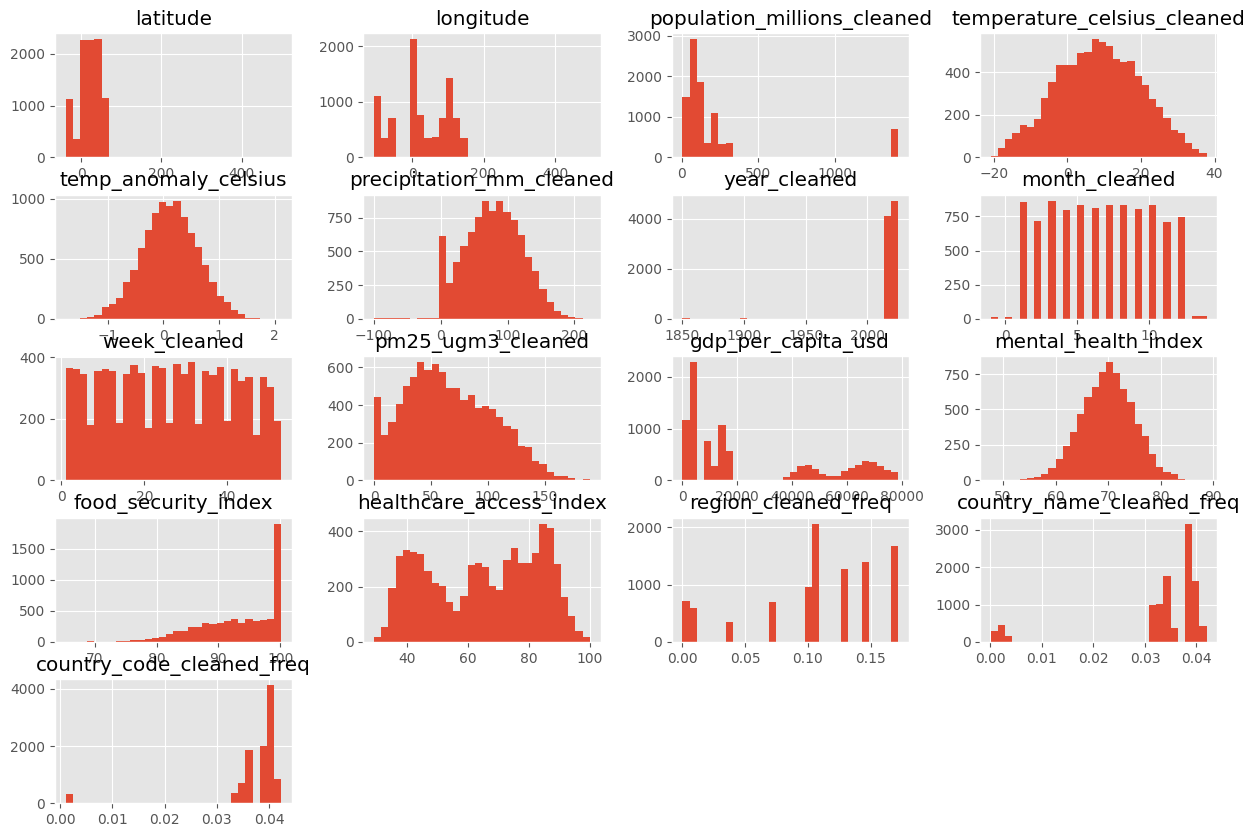

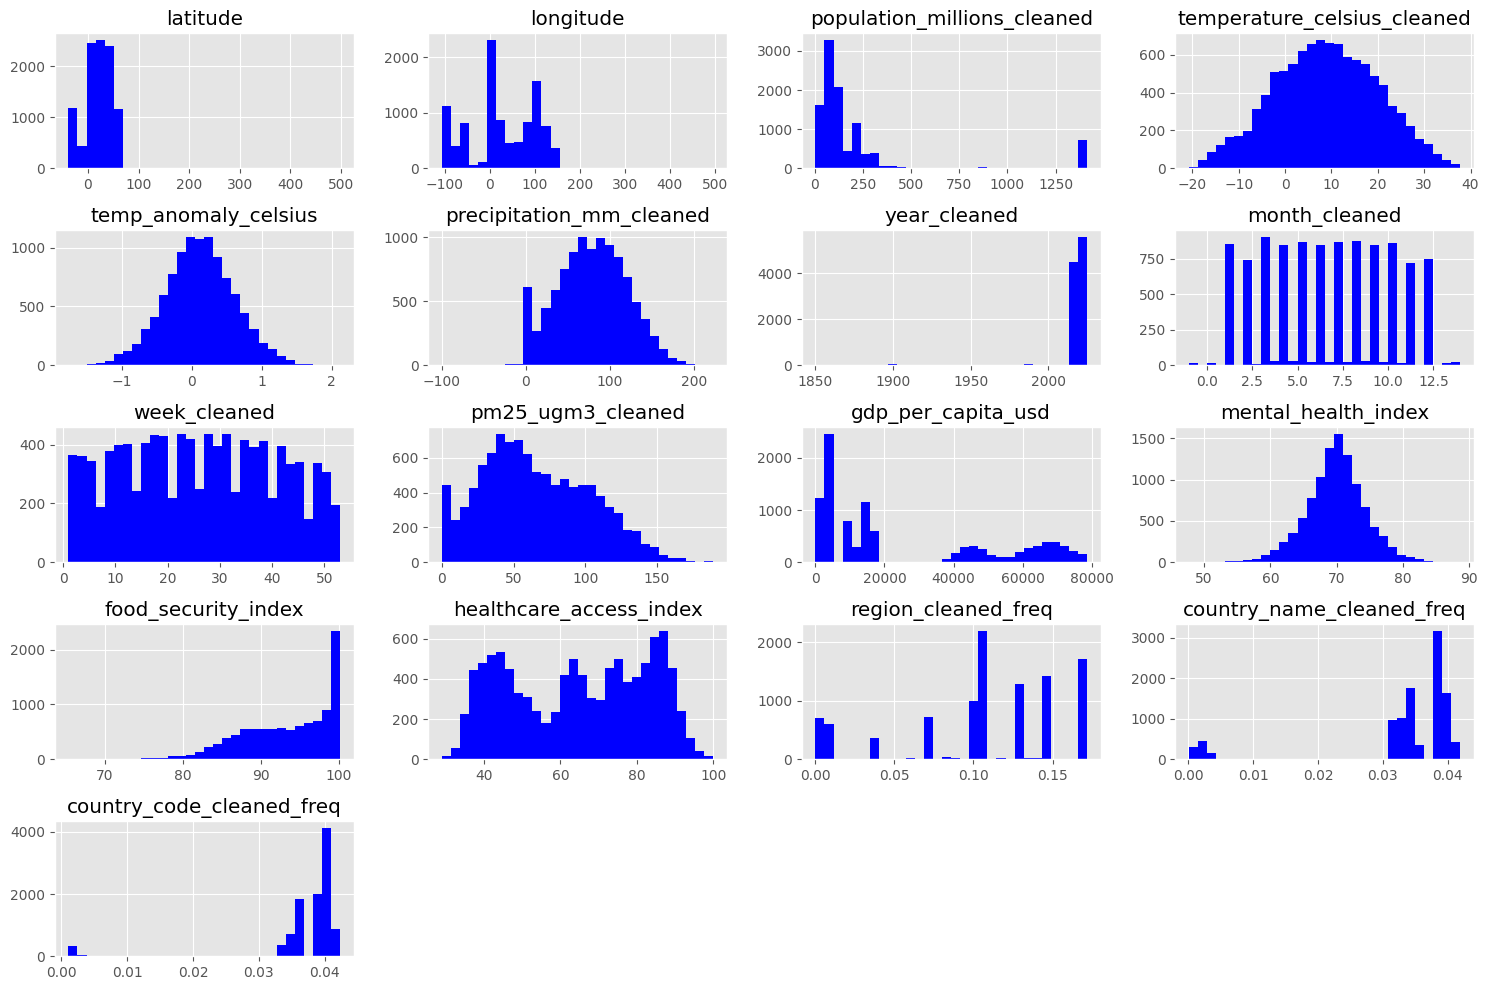

In [150]:
X_train[num_cols].hist(bins=30, figsize=(15, 10))
pd.DataFrame(X_train_num_imputed,columns=num_cols).hist(bins=30, figsize=(15, 10),color='blue')
plt.tight_layout()
plt.show()

In [151]:
# pd.DataFrame(X_train_num_imputed,columns=num_cols).hist(bins=30, figsize=(15, 10))
# plt.tight_layout()
# plt.show()

In [152]:
X_train_num_imputed.shape

(10273, 17)

In [153]:
from sklearn.impute import SimpleImputer

se = SimpleImputer(strategy='most_frequent')
X_train_cat_imputed = se.fit_transform(X_train[cat_cols])
X_test_cat_imputed = se.transform(X_test[cat_cols])

In [154]:
X_train_num_imputed.shape

(10273, 17)

## Scaling

In [155]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_num_imputed)
X_test_scaled = scaler.transform(X_test_num_imputed)

### Concatenate both

In [156]:
X_train_cat_imputed = pd.DataFrame(X_train_cat_imputed,columns=cat_cols)
X_test_cat_imputed = pd.DataFrame(X_test_cat_imputed,columns=cat_cols)

X_train_scaled = pd.DataFrame(X_train_scaled,columns=num_cols)
X_test_scaled = pd.DataFrame(X_test_scaled,columns=num_cols)

In [157]:
X_train_final = pd.concat([
    X_train_cat_imputed,
    X_train_scaled
], axis=1) 

X_test_final = pd.concat([
    X_test_cat_imputed,
    X_test_scaled
], axis=1) 

In [158]:
# corr_matrix = X_train_final.corr()
# plt.figure(figsize=(14, 12))
# sns.heatmap(corr_matrix, annot=True, fmt=".2f", 
#             cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
# plt.title('Correlation Matrix (Numerical Features vs Target)')
# plt.show()

In [159]:
# X_train_final['air_quality_index'].corr(y_train),X_train_final['pm25_ugm3_cleaned'].corr(y_train)

In [160]:
# X_train_final['gdp_per_capita_usd'].corr(y_train),X_train_final['income_level_cleaned'].corr(y_train)

In [161]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weight_dict = dict(zip(classes, class_weights))
class_weight_dict


{np.int64(0): np.float64(1.2425012094823416),
 np.int64(1): np.float64(0.7163877266387727),
 np.int64(2): np.float64(0.840671031096563),
 np.int64(3): np.float64(1.640006385696041)}

In [162]:
from sklearn import linear_model
logr = linear_model.LogisticRegression(max_iter=1000,solver='saga',random_state=42)
logr.fit(X_train_final,y_train)
preds = logr.predict(X_test_final)

In [163]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.55      0.37      0.44       524
           1       0.47      0.59      0.52       876
           2       0.53      0.55      0.54       758
           3       0.76      0.64      0.70       411

    accuracy                           0.54      2569
   macro avg       0.58      0.54      0.55      2569
weighted avg       0.55      0.54      0.54      2569



In [164]:
from xgboost import XGBClassifier

sample_weights = y_train.map(class_weight_dict)
xg = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42

)
xg.fit(X_train_final,y_train,sample_weight=sample_weights)
preds_xg = xg.predict(X_test_final)
print(classification_report(y_test, preds_xg))

              precision    recall  f1-score   support

           0       0.52      0.58      0.55       524
           1       0.50      0.43      0.46       876
           2       0.55      0.57      0.56       758
           3       0.70      0.73      0.72       411

    accuracy                           0.55      2569
   macro avg       0.57      0.58      0.57      2569
weighted avg       0.55      0.55      0.55      2569



In [165]:
from sklearn.multiclass import OneVsOneClassifier

# One-vs-One creates more decision boundaries between similar classes
ovo_xgb = OneVsOneClassifier(
    XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.2,
                  random_state=42)
)

ovo_xgb.fit(X_train_final, y_train)
preds_ovo = ovo_xgb.predict(X_test_final)

print(classification_report(y_test, preds_ovo))

              precision    recall  f1-score   support

           0       0.58      0.44      0.50       524
           1       0.51      0.57      0.54       876
           2       0.56      0.59      0.58       758
           3       0.77      0.71      0.73       411

    accuracy                           0.57      2569
   macro avg       0.60      0.58      0.59      2569
weighted avg       0.58      0.57      0.57      2569



In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer, f1_score, accuracy_score
# rf = RandomForestClassifier(
#     random_state=42,
#     n_jobs=-1,
# )

# param_grid = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [None, 5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', 0.5],
#     'class_weight': [None, 'balanced'] 
# }
# scorer = make_scorer(f1_score, average='macro')  # multiclass-safe
# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     scoring=scorer,
#     cv=5,                # 5-fold cross-validation
#     n_jobs=-1,
#     verbose=2,
#     refit=True
# )

In [ ]:
# grid_search.fit(X_train_final, y_train)
# y_pred = best_rf.predict(X_test_final)
# print(classification_report(y_test, y_pred))

In [166]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=50,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced')

rf.fit(X_train_final,y_train)

preds_rf = rf.predict(X_test_final)
print(classification_report(y_test, preds_rf))

              precision    recall  f1-score   support

           0       0.60      0.41      0.49       524
           1       0.51      0.61      0.56       876
           2       0.58      0.61      0.60       758
           3       0.79      0.68      0.73       411

    accuracy                           0.58      2569
   macro avg       0.62      0.58      0.59      2569
weighted avg       0.59      0.58      0.58      2569



In [167]:
X_train_final.columns

Index(['extreme_weather_events_round', 'latitude', 'longitude',
       'population_millions_cleaned', 'temperature_celsius_cleaned',
       'temp_anomaly_celsius', 'precipitation_mm_cleaned', 'year_cleaned',
       'month_cleaned', 'week_cleaned', 'pm25_ugm3_cleaned',
       'gdp_per_capita_usd', 'mental_health_index', 'food_security_index',
       'healthcare_access_index', 'region_cleaned_freq',
       'country_name_cleaned_freq', 'country_code_cleaned_freq'],
      dtype='object')

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

brf.fit(X_train_final, y_train)
y_pred = brf.predict(X_test_final)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
from imblearn.ensemble import EasyEnsembleClassifier

eec = EasyEnsembleClassifier(
    n_estimators=10,
    random_state=42
)


eec.fit(X_train_final, y_train)
y_pred_eec = eec.predict(X_test_final)

In [ ]:
print(classification_report(y_test, y_pred_eec))

In [ ]:
from sklearn.inspection import permutation_importance
sort = rf.feature_importances_.argsort()

plt.barh(X_train_final.columns[sort], rf.feature_importances_[sort])

plt.xlabel("Feature Importance")

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cross_val_results = cross_val_score(rf, X_train_final, y_train, cv=kf)
cross_val_results

In [ ]:
cross_val_results_ovo = cross_val_score(ovo_xgb, X_train_final, y_train, cv=kf)
cross_val_results_ovo

In [171]:
X_train.describe()

,latitude,longitude,income_level_cleaned,population_millions_cleaned,temperature_celsius_cleaned,temp_anomaly_celsius,precipitation_mm_cleaned,heat_wave_days_round,drought_indicator_cleaned,flood_indicator_cleaned,extreme_weather_events_round,air_quality_index,pm25_ugm3_cleaned,gdp_per_capita_usd,mental_health_index,food_security_index,healthcare_access_index,year_cleaned,month_cleaned,week_cleaned,region_cleaned_freq,country_name_cleaned_freq,country_code_cleaned_freq
count,9574.000000,9047.000000,9598.000000,9094.000000,8414.000000,9663.000000,9250.000000,9710.000000,9508.000000,9283.000000,9761.000000,8832.000000,9421.000000,9499.000000,7298.000000,6466.000000,6830.000000,8878.000000,9724.000000,9253.000000,9752.000000,10273.000000,10273.000000
mean,22.063620,30.739865,1.012919,214.387206,8.627662,0.117677,77.916831,0.148816,0.011254,0.005386,0.167401,102.056855,65.945886,26090.388102,69.879027,93.401042,64.797770,2018.845911,6.437577,26.199611,0.106766,0.033577,0.037483
std,40.554962,83.751707,0.851627,352.719267,11.432396,0.503967,43.128858,0.457478,0.105490,0.073197,0.480188,57.669300,38.156729,26239.396504,5.039204,6.311339,18.235515,12.694463,3.454723,14.856331,0.051513,0.010382,0.007098
min,-38.443338,-106.375592,0.000000,3.855693,-20.740000,-1.760000,-99.631111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.111897,47.700000,65.300000,29.000000,1850.000000,-1.000000,1.000000,0.000103,0.000097,0.001071
25%,4.570000,-3.740000,0.000000,60.000000,0.154988,-0.220000,47.200000,0.000000,0.000000,0.000000,0.000000,57.000000,36.800000,3542.000000,66.500000,88.800000,46.925000,2017.000000,3.000000,13.000000,0.099159,0.033388,0.036601
50%,23.630000,22.930000,1.000000,98.000000,8.580000,0.119980,78.600000,0.000000,0.000000,0.000000,0.000000,95.000000,61.500000,13806.000000,70.000000,94.600000,66.200000,2020.000000,6.000000,26.000000,0.108080,0.037769,0.039424
75%,37.090000,100.990000,2.000000,206.000000,16.970000,0.460000,108.975000,0.000000,0.000000,0.000000,0.000000,144.000000,94.300000,49644.009856,73.300000,100.000000,81.400000,2023.000000,9.000000,39.000000,0.143458,0.038937,0.040397
max,497.991552,497.100924,2.000000,1412.914623,37.832000,2.120000,222.900000,5.000000,1.000000,1.000000,5.000000,302.000000,189.500000,78630.000000,88.700000,100.177448,100.000000,2025.000000,14.000000,53.000000,0.171760,0.041955,0.042344


In [169]:
df_test.describe()

,record_id,year,month,week,latitude,longitude,population_millions,temperature_celsius,temp_anomaly_celsius,precipitation_mm,heat_wave_days,drought_indicator,flood_indicator,extreme_weather_events,pm25_ugm3,air_quality_index,healthcare_access_index,gdp_per_capita_usd,mental_health_index,food_security_index
count,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000
mean,846.500000,2019.986407,6.611702,26.907801,18.011649,29.875035,216.570922,8.873629,0.110248,81.143144,0.135934,0.009456,0.008274,0.153664,65.668262,98.449173,64.786820,25961.238771,69.670213,93.356442
std,488.582644,3.062013,3.420110,14.888103,25.855142,75.920808,355.503521,11.414132,0.513644,41.205990,0.425902,0.096811,0.090612,0.453678,37.543034,58.082450,18.051803,25949.084327,5.057122,6.114147
min,1.000000,2015.000000,1.000000,1.000000,-38.410000,-106.340000,26.000000,-20.400000,-1.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-33.000000,30.200000,1567.000000,49.700000,65.200000
25%,423.750000,2017.000000,4.000000,14.750000,-0.020000,-3.740000,60.000000,0.557500,-0.250000,50.625000,0.000000,0.000000,0.000000,0.000000,37.650000,55.000000,47.675000,3458.000000,66.100000,89.175000
50%,846.500000,2020.000000,7.000000,27.000000,23.630000,22.930000,98.000000,8.575000,0.130000,80.450000,0.000000,0.000000,0.000000,0.000000,59.950000,92.000000,65.600000,14202.000000,70.000000,94.500000
75%,1269.250000,2023.000000,10.000000,40.000000,37.090000,100.990000,206.000000,16.865000,0.460000,110.700000,0.000000,0.000000,0.000000,0.000000,95.125000,140.250000,81.425000,49696.000000,73.100000,99.500000
max,1692.000000,2025.000000,12.000000,53.000000,56.130000,138.250000,1411.000000,37.630000,1.720000,208.800000,4.000000,1.000000,1.000000,5.000000,185.100000,269.000000,99.700000,78415.000000,85.000000,100.000000


In [ ]:
df_test['income_level'].value_counts()

In [175]:
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['date']

0      2016-06-05
1      2024-07-21
2      2022-10-09
3      2019-09-01
4      2021-08-01
          ...    
1687   2017-03-19
1688   2023-07-23
1689   2021-01-10
1690   2020-09-06
1691   2024-08-18
Name: date, Length: 1692, dtype: datetime64[ns]

In [182]:
df_test['year_cleaned'] = df_test['date'].dt.year
df_test['month_cleaned'] = df_test['date'].dt.month
df_test['week_cleaned'] = df_test['date'].dt.isocalendar().week

In [183]:
df_test['month_cleaned'].describe(),df_test['week_cleaned'].describe(),df_test['year_cleaned'].describe()

(count    1692.000000
 mean        6.611702
 std         3.420110
 min         1.000000
 25%         4.000000
 50%         7.000000
 75%        10.000000
 max        12.000000
 Name: month_cleaned, dtype: float64,
 count       1692.0
 mean     26.907801
 std      14.888103
 min            1.0
 25%          14.75
 50%           27.0
 75%           40.0
 max           53.0
 Name: week_cleaned, dtype: Float64,
 count    1692.000000
 mean     2019.986407
 std         3.062013
 min      2015.000000
 25%      2017.000000
 50%      2020.000000
 75%      2023.000000
 max      2025.000000
 Name: year_cleaned, dtype: float64)

In [184]:
df_test['region_cleaned'] = df_test['region']
df_test['country_name_cleaned'] = df_test['country_name']
df_test['country_code_cleaned'] = df_test['country_code']

In [185]:
# ## for test dataset

# df_test = df_test.rename(columns={
#     'income_level' : 'income_level_cleaned',
#     'population_millions': 'population_millions_cleaned',
#     'temperature_celsius': 'temperature_celsius_cleaned',
#     'precipitation_mm': 'precipitation_mm_cleaned',
#     'pm25_ugm3': 'pm25_ugm3_cleaned'
# })
# df_test['income_level_']

In [186]:
df_test['income_level_cleaned'] = (
    df_test['income_level']
    .str.lower()
    .str.strip()
)
df_test['income_level_cleaned'] = encoder.transform(df_test[['income_level_cleaned']])

In [187]:
df_test

,record_id,country_code,country_name,region,income_level,date,year,month,week,latitude,longitude,population_millions,temperature_celsius,temp_anomaly_celsius,precipitation_mm,heat_wave_days,drought_indicator,flood_indicator,extreme_weather_events,pm25_ugm3,air_quality_index,healthcare_access_index,gdp_per_capita_usd,mental_health_index,food_security_index,month_cleaned,week_cleaned,year_cleaned,region_cleaned,country_name_cleaned,country_code_cleaned,income_level_cleaned
0,1,PHL,Philippines,Southeast Asia,Lower-Middle,2016-06-05,2016,6,22,12.87,121.77,110,21.93,0.58,90.9,0,0,0,0,102.9,153,34.7,2959,72.6,85.7,6,22,2016,Southeast Asia,Philippines,PHL,0.0
1,2,ARG,Argentina,South America,Upper-Middle,2024-07-21,2024,7,29,-38.41,-63.61,45,0.01,-0.47,48.0,0,0,0,0,19.7,26,64.3,15480,69.0,94.2,7,29,2024,South America,Argentina,ARG,1.0
2,3,MEX,Mexico,North America,Upper-Middle,2022-10-09,2022,10,40,23.63,-102.55,129,2.18,-0.18,0.0,0,0,0,0,50.7,78,66.9,16895,68.8,88.9,10,40,2022,North America,Mexico,MEX,1.0
3,4,AUS,Australia,Oceania,High,2019-09-01,2019,9,35,-25.27,133.77,26,3.58,-0.32,61.1,0,0,0,0,35.3,51,78.0,47233,60.1,100.0,9,35,2019,Oceania,Australia,AUS,2.0
4,5,COL,Colombia,South America,Upper-Middle,2021-08-01,2021,8,30,4.57,-74.29,51,15.42,0.82,79.9,0,0,0,0,34.8,52,76.2,9731,73.2,100.0,8,30,2021,South America,Colombia,COL,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687,1688,AUS,Australia,Oceania,High,2017-03-19,2017,3,11,-25.27,133.77,26,18.33,0.35,143.0,1,0,0,1,75.7,121,83.0,45077,65.6,97.0,3,11,2017,Oceania,Australia,AUS,2.0
1688,1689,ARG,Argentina,South America,Upper-Middle,2023-07-23,2023,7,29,-38.41,-63.61,45,0.10,-0.14,112.4,0,0,0,0,54.6,101,64.4,15220,80.4,91.4,7,29,2023,South America,Argentina,ARG,1.0
1689,1690,AUS,Australia,Oceania,High,2021-01-10,2021,1,1,-25.27,133.77,26,9.09,-0.56,96.0,0,0,0,0,25.4,23,75.8,48384,65.6,93.5,1,1,2021,Oceania,Australia,AUS,2.0
1690,1691,IND,India,South Asia,Lower-Middle,2020-09-06,2020,9,36,20.59,78.96,1380,4.69,0.13,32.8,0,0,0,0,136.0,207,47.6,2750,80.9,80.8,9,36,2020,South Asia,India,IND,0.0


In [188]:
freq_cols = ['region_cleaned', 'country_name_cleaned', 'country_code_cleaned']
for col in freq_cols:
    df_test[f'{col}_freq'] = df_test[col].map(freq_maps[col])

In [189]:
# cat_cols = [
#     # 'income_level_cleaned',
#             'drought_indicator_cleaned','flood_indicator_cleaned',
#             'extreme_weather_events_round']
# num_cols = ['latitude','longitude','population_millions_cleaned','temperature_celsius_cleaned',
#            'temp_anomaly_celsius','precipitation_mm_cleaned',
#             # 'air_quality_index',
#             'pm25_ugm3_cleaned',
#            'gdp_per_capita_usd','mental_health_index','food_security_index',
#             # 'healthcare_access_index',
#             'region_cleaned_freq','country_name_cleaned_freq','country_code_cleaned_freq']

In [190]:
df_test['population_millions_cleaned'] = df_test['population_millions']
df_test['temperature_celsius_cleaned'] = df_test['temperature_celsius']
df_test['precipitation_mm_cleaned'] = df_test['precipitation_mm']
df_test['pm25_ugm3_cleaned'] = df_test['pm25_ugm3']
df_test['heat_wave_days_round'] = df_test['heat_wave_days']
df_test['drought_indicator_cleaned'] = df_test['drought_indicator']
df_test['flood_indicator_cleaned'] = df_test['flood_indicator']
df_test['extreme_weather_events_round'] = df_test['extreme_weather_events']


In [191]:
df_test[num_cols] = scaler.transform(df_test[num_cols])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [192]:
df_test

,record_id,country_code,country_name,region,income_level,date,year,month,week,latitude,longitude,population_millions,temperature_celsius,temp_anomaly_celsius,precipitation_mm,heat_wave_days,drought_indicator,flood_indicator,extreme_weather_events,pm25_ugm3,air_quality_index,healthcare_access_index,gdp_per_capita_usd,mental_health_index,food_security_index,month_cleaned,week_cleaned,year_cleaned,region_cleaned,country_name_cleaned,country_code_cleaned,income_level_cleaned,region_cleaned_freq,country_name_cleaned_freq,country_code_cleaned_freq,population_millions_cleaned,temperature_celsius_cleaned,precipitation_mm_cleaned,pm25_ugm3_cleaned,heat_wave_days_round,drought_indicator_cleaned,flood_indicator_cleaned,extreme_weather_events_round
0,1,PHL,Philippines,Southeast Asia,Lower-Middle,2016-06-05,2016,6,22,-0.223141,1.123168,110,21.93,0.940947,90.9,0,0,0,0,102.9,153,-1.674225,-0.887761,0.611405,-1.325778,-0.127888,-0.285054,-0.219679,Southeast Asia,Philippines,PHL,0.0,NaN,NaN,NaN,-0.303782,1.171722,0.304900,0.988012,0,0,0,0
1,2,ARG,Argentina,South America,Upper-Middle,2024-07-21,2024,7,29,-1.519035,-1.155401,45,0.01,-1.193220,48.0,0,0,0,0,19.7,26,-0.019974,-0.409961,-0.202495,0.138266,0.165213,0.200877,0.437291,South America,Argentina,ARG,1.0,NaN,NaN,NaN,-0.492834,-0.797981,-0.720137,-1.228428,0,0,0,0
2,3,MEX,Mexico,North America,Upper-Middle,2022-10-09,2022,10,40,0.048774,-1.634026,129,2.18,-0.603783,0.0,0,0,0,0,50.7,78,0.125331,-0.355965,-0.247712,-0.774609,1.044516,0.964481,0.273049,North America,Mexico,MEX,1.0,NaN,NaN,NaN,-0.248520,-0.602988,-1.867031,-0.402591,0,0,0,0
3,4,AUS,Australia,Oceania,High,2019-09-01,2019,9,35,-1.186975,1.270664,26,3.58,-0.888339,61.1,0,0,0,0,35.3,51,0.745676,0.801730,-2.214639,1.137260,0.751415,0.617388,0.026685,Oceania,Australia,AUS,2.0,NaN,NaN,NaN,-0.548095,-0.477186,-0.407131,-0.812845,0,0,0,0
4,5,COL,Colombia,South America,Upper-Middle,2021-08-01,2021,8,30,-0.432890,-1.286672,51,15.42,1.428757,79.9,0,0,0,0,34.8,52,0.645079,-0.629342,0.747056,1.137260,0.458314,0.270295,0.190928,South America,Colombia,COL,1.0,NaN,NaN,NaN,-0.475383,0.586742,0.042070,-0.826165,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687,1688,AUS,Australia,Oceania,High,2017-03-19,2017,3,11,-1.186975,1.270664,26,18.33,0.473463,143.0,1,0,0,1,75.7,121,1.025110,0.719458,-0.971179,0.620539,-1.007192,-1.048658,-0.137557,Oceania,Australia,AUS,2.0,NaN,NaN,NaN,-0.548095,0.848230,1.549758,0.263407,1,0,0,1
1688,1689,ARG,Argentina,South America,Upper-Middle,2023-07-23,2023,7,29,-1.519035,-1.155401,45,0.10,-0.522482,112.4,0,0,0,0,54.6,101,-0.014386,-0.419883,2.374857,-0.344008,0.165213,0.200877,0.355170,South America,Argentina,ARG,1.0,NaN,NaN,NaN,-0.492834,-0.789894,0.818613,-0.298695,0,0,0,0
1689,1690,AUS,Australia,Oceania,High,2021-01-10,2021,1,1,-1.186975,1.270664,26,9.09,-1.376148,96.0,0,0,0,0,25.4,23,0.622724,0.845652,-0.971179,0.017697,-1.593394,-1.742844,0.190928,Oceania,Australia,AUS,2.0,NaN,NaN,NaN,-0.548095,0.017936,0.426757,-1.076580,0,0,0,0
1690,1691,IND,India,South Asia,Lower-Middle,2020-09-06,2020,9,36,-0.028050,0.596975,1380,4.69,0.026304,32.8,0,0,0,0,136.0,207,-0.953285,-0.895737,2.487899,-2.169756,0.751415,0.686807,0.108806,South Asia,India,IND,0.0,NaN,NaN,NaN,3.390004,-0.377443,-1.083320,1.869793,0,0,0,0


In [193]:
# 'heat_wave_days_round', 'drought_indicator_cleaned', 'flood_indicator_cleaned', 'extreme_weather_events_round'

In [194]:
X_train_final.columns

Index(['extreme_weather_events_round', 'latitude', 'longitude',
       'population_millions_cleaned', 'temperature_celsius_cleaned',
       'temp_anomaly_celsius', 'precipitation_mm_cleaned', 'year_cleaned',
       'month_cleaned', 'week_cleaned', 'pm25_ugm3_cleaned',
       'gdp_per_capita_usd', 'mental_health_index', 'food_security_index',
       'healthcare_access_index', 'region_cleaned_freq',
       'country_name_cleaned_freq', 'country_code_cleaned_freq'],
      dtype='object')

In [195]:
predictions = rf.predict_proba(df_test[X_train_final.columns])

In [196]:
predictions

array([[0.01333333, 0.05666667, 0.27333333, 0.65666667],
       [0.52      , 0.34      , 0.13      , 0.01      ],
       [0.28666667, 0.47      , 0.22333333, 0.02      ],
       ...,
       [0.5521143 , 0.33455237, 0.10333333, 0.01      ],
       [0.00333333, 0.29333333, 0.68333333, 0.02      ],
       [0.02666667, 0.16333333, 0.67073559, 0.13926441]])

In [197]:
submission = pd.DataFrame({
    'record_id': df_test['record_id'],
    'Low_Risk': predictions[:, 0],
    'Moderate_Risk': predictions[:, 1],
    'High_Risk': predictions[:, 2],
    'Critical_Risk': predictions[:, 3]
})
submission.to_csv('submission.csv', index=False)

In [ ]:
submission.shape

## Modular Pipeline - Clean Flow

In [ ]:
# 1. Load Data
df_train = pd.read_csv('/kaggle/input/datathon-techparva-2026/train.csv')
df_test_raw = pd.read_csv("/kaggle/input/datathon-techparva-2026/test.csv")

# 2. Process Training Data
X, y = process_train_data(df_train)

# 3. Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Ordinal Encoding
ordinal_features = ['income_level_cleaned']
categories = [['lower-middle', 'upper-middle', 'high']]
X_train, X_val, ordinal_encoder = apply_ordinal_encoding(X_train, X_val, ordinal_features, categories)

# 5. Frequency Encoding
freq_cols = ['region_cleaned', 'country_name_cleaned', 'country_code_cleaned']
X_train, X_val, freq_maps = apply_frequency_encoding(X_train, X_val, freq_cols)

# 6. Define Column Groups
cat_cols = ['extreme_weather_events_round']
num_cols = ['latitude', 'longitude', 'population_millions_cleaned', 'temperature_celsius_cleaned',
            'temp_anomaly_celsius', 'precipitation_mm_cleaned', 'year_cleaned', 'month_cleaned', 
            'week_cleaned', 'pm25_ugm3_cleaned', 'gdp_per_capita_usd', 'mental_health_index', 
            'food_security_index', 'healthcare_access_index', 'region_cleaned_freq', 
            'country_name_cleaned_freq', 'country_code_cleaned_freq']

# 7. Imputation and Scaling
X_train_final, X_val_final, knn_imputer, simple_imputer, scaler = impute_and_scale(
    X_train, X_val, num_cols, cat_cols
)

# 8. Train Model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=300, max_depth=50, random_state=42, n_jobs=-1, class_weight='balanced')
model.fit(X_train_final, y_train)

# 9. Evaluate
from sklearn.metrics import classification_report
preds = model.predict(X_val_final)
print(classification_report(y_val, preds))

# 10. Prepare Test Data for Submission
X_submission = prepare_submission_data(df_test_raw, ordinal_encoder, freq_maps, scaler, num_cols, X_train_final.columns)

# 11. Create Submission
submission = create_submission(model, X_submission, df_test_raw['record_id'], 'submission_modular.csv')
print(f"Submission shape: {submission.shape}")